# Conducting Between Analysis Between Region

Here we conduct physical analysis between basins.

1) We download a handful of floats into a parquet and estimate potential density and calculate MLD

2) Expansion into a larger dataset, Here we expand nº1 into a larger dataset and seperating into regions

In [145]:
# Libraries for data handling

import polars as pl
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Library for estimating oceanographic parameters
import gsw

# Library for donwloading data

import os
from pathlib import Path
import argopy
from argopy import DataFetcher

In [146]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
xr.set_options(display_expand_attrs = False)

import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

# Downloading Handful of floats

Downloading speific floats and estiamte physical parameters

## Downloading Floats 

In [147]:
# Base filepath
root = '../data/argo/'
profile_dir = root + 'Profiles/'

# Create GO-BGC folders if they do not exist yet
if 'argo' not in os.listdir('../data/'):
  os.mkdir(root)
if 'Profiles' not in os.listdir(root):
  os.mkdir(profile_dir)

# Downloading data using argopy
float_ids = [6903871, 6902882, 6902802, 6901627, 6902807, 6901601, 6901029]  # Ice Shelf and Open Ocean Floats

# Fetching data
ds = DataFetcher(src ='gdac', 
                 mode = 'standard').float(
                     float_ids).to_xarray()

# Quality Control Filtering
ds = ds.argo.filter_qc(QC_list=[1,2])  # Keep only good and probably good data

# Downloading data using argopy

ds = ds.to_dataframe().reset_index()
ds = pl.from_pandas(ds)

# Saving in one dataset parquet
out_path = Path(profile_dir)/ f"Grouped_data_set.parquet"
out_path.parent.mkdir(parents=True, exist_ok=True)

ds.write_parquet(out_path)
print(f"Saved all float in one parquet -> {profile_dir}")

# Saving by Float number
#for fid in float_ids:
#    sub = ds.filter(pl.col("PLATFORM_NUMBER") == fid)
#    out_path = Path(profile_dir)/ f"{fid}.parquet"
#    out_path.parent.mkdir(parents=True, exist_ok=True)
#    sub.write_parquet(out_path)
#    print(f"Saved float {fid} -> {profile_dir}")


KeyboardInterrupt: 

## Comparing Basins

Creating Function:

1) density Calcl
2) Sigma0 Potential density
3) Estimating Mixlayer depth using the density threshold of ~0.3

In [ ]:
# Defining Function

"""
  In site density Calculation Function.
Using Gibbs SeaWater (GSW) Oceanographic Toolbox, it is added as 
another column to the Polars DataFrame.
"""
def add_density(df: pl.DataFrame) -> pl.DataFrame:
    # Extract numpy arrays
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    # Compute absolute salinity, conservative temperature, density
    SA  = gsw.SA_from_SP(SP, p, lon, lat)
    CT  = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)

    # Append new column as a Polars Series
    return df.with_columns(pl.Series("RHO", rho))

# Creating potential density function (for MLD calculations)
def add_sigma0(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add potential density anomaly sigma0 [kg/m^3 - 1000] as a column 'SIGMA0'.
    Requires PSAL [PSS-78], TEMP [°C in-situ], PRES [dbar], LONGITUDE [degE], LATITUDE [degN].
    """
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)  # kg/m^3 - 1000
    return df.with_columns(pl.Series("SIGMA0", sigma0))

# Creating Mixed Layer Depth function for MLD calculations
"""
 Calculation based on de Montety et al. (2014) definition:
"""
# Compute MLD per profile
def compute_mld_for_profile(pres: np.ndarray, sigma0: np.ndarray,
                            ref_depth: float = 10.0, drho_threshold: float = 0.03) -> float:
    sort_idx = np.argsort(pres)
    pres_sorted = pres[sort_idx]
    sigma0_sorted = sigma0[sort_idx]
    idx_ref = np.argmin(np.abs(pres_sorted - ref_depth))
    sigma0_ref = sigma0_sorted[idx_ref]
    sigma0_th = sigma0_ref + drho_threshold
    mask = sigma0_sorted >= sigma0_th
    mask[:(idx_ref+1)] = False
    if not np.any(mask):
        return np.nan
    idx_mld = np.where(mask)[0][0]
    return float(pres_sorted[idx_mld])





In [ ]:
# Loading data 
df = pl.read_parquet('../data/argo/profiles/Grouped_data_set.parquet')

# Filtering data below 500m
#df = df.filter(pl.col('PRES') < 500)

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing CHL per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()




N_POINTS,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ERROR,PRES_QC,PSAL,PSAL_ERROR,PSAL_QC,TEMP,TEMP_ERROR,TEMP_QC,TIME_QC,TIME,LATITUDE,LONGITUDE,SIGMA0,MLD
i64,i64,str,str,i64,i64,f32,f32,i64,f32,f32,i64,f32,f32,i64,i64,datetime[ns],f64,f64,f64,f64
0,1,"""D""","""D""",6901029,1,17.0,2.4,1,34.799999,0.01,1,11.131,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,26.600054,17.0
1,1,"""D""","""D""",6901029,1,24.0,2.4,1,34.882,0.01,1,8.478,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.111274,17.0
2,1,"""D""","""D""",6901029,1,34.0,2.4,1,34.872002,0.01,1,6.765,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.352959,17.0
3,1,"""D""","""D""",6901029,1,45.0,2.4,1,34.865002,0.01,1,6.177,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.425852,17.0
4,1,"""D""","""D""",6901029,1,55.0,2.4,1,34.896,0.01,1,5.682,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.513338,17.0


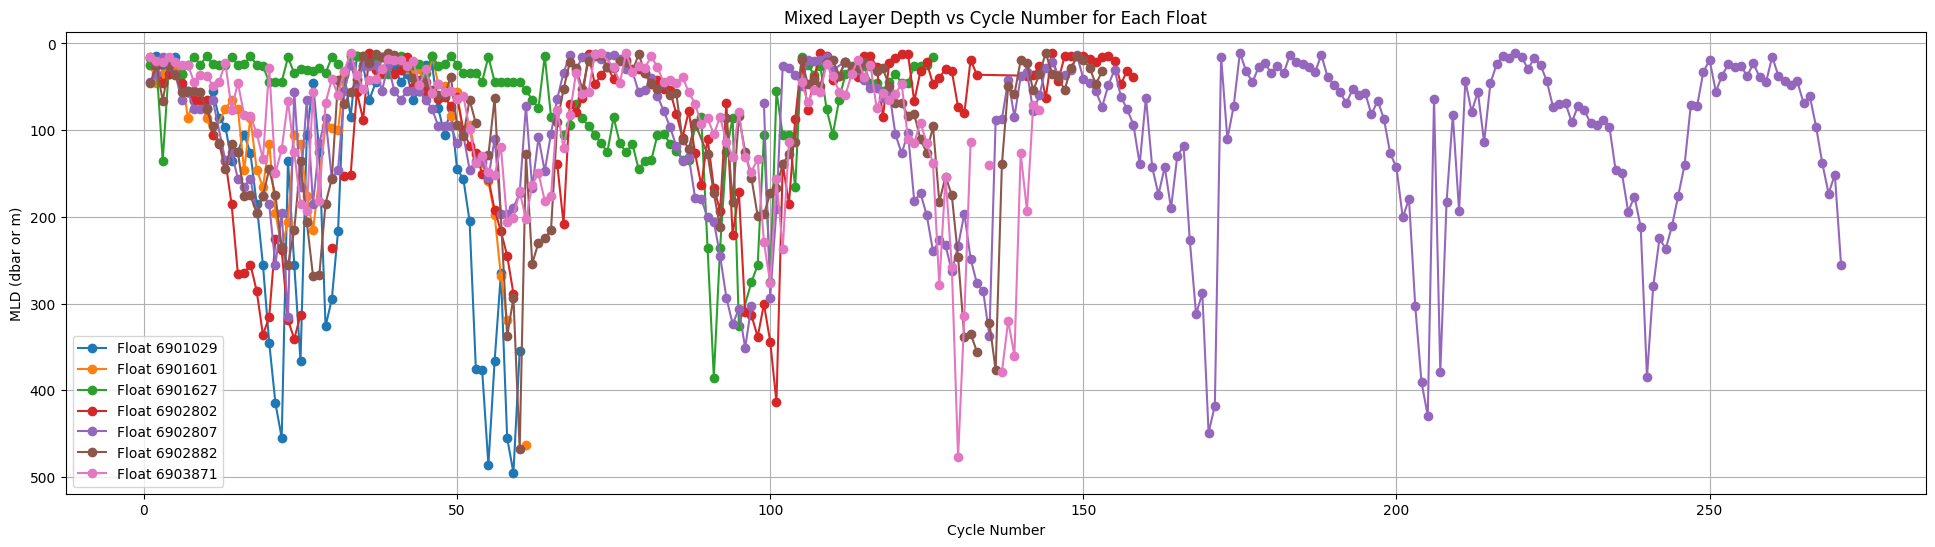

In [ ]:
# Plotting df

cycle_summary = (df.
                 select("PLATFORM_NUMBER", "CYCLE_NUMBER", "MLD")
                 .unique()
                 .sort("PLATFORM_NUMBER", "CYCLE_NUMBER"))

summary_pd = cycle_summary.to_pandas()


fig, ax = plt.subplots(figsize=(24,6))
for float_id, sub in summary_pd.groupby("PLATFORM_NUMBER"):
    ax.plot(sub["CYCLE_NUMBER"], sub["MLD"],
            marker="o", label=f"Float {float_id}")

ax.set_xlabel("Cycle Number")
ax.set_ylabel("MLD (dbar or m)")
ax.set_title("Mixed Layer Depth vs Cycle Number for Each Float")
ax.invert_yaxis()  # optional: deeper = larger depth, so invert if you want shallow at top
ax.legend()
plt.grid(True)
plt.show()

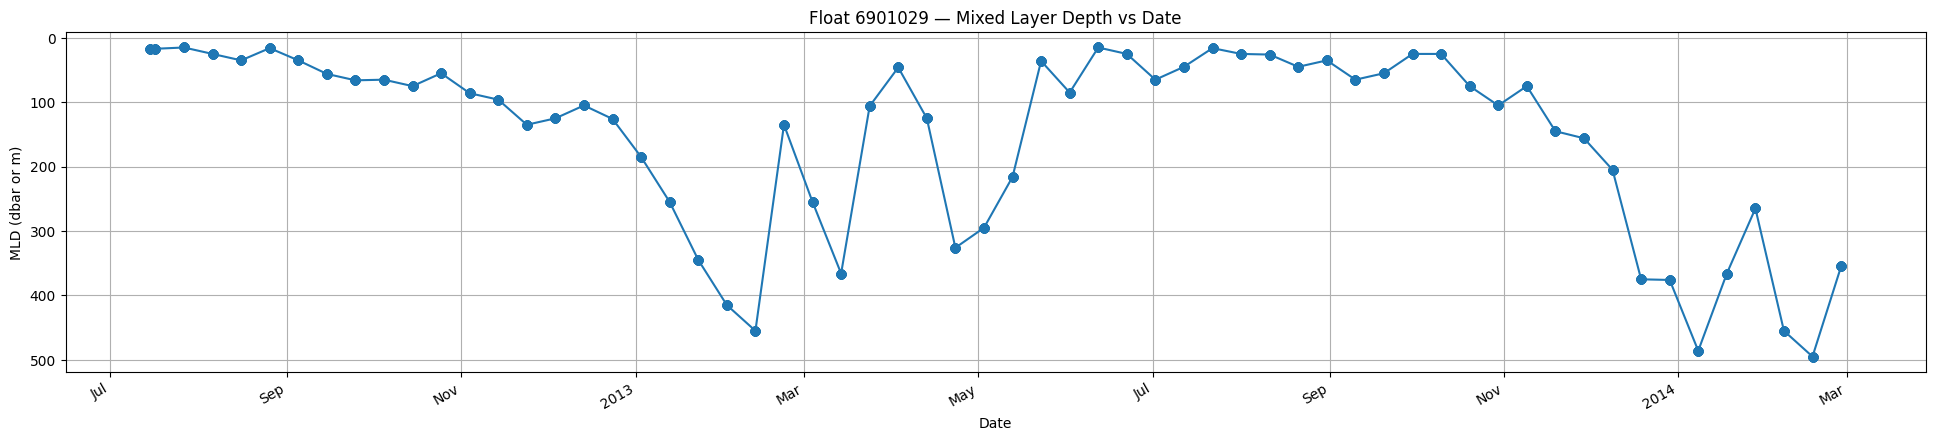

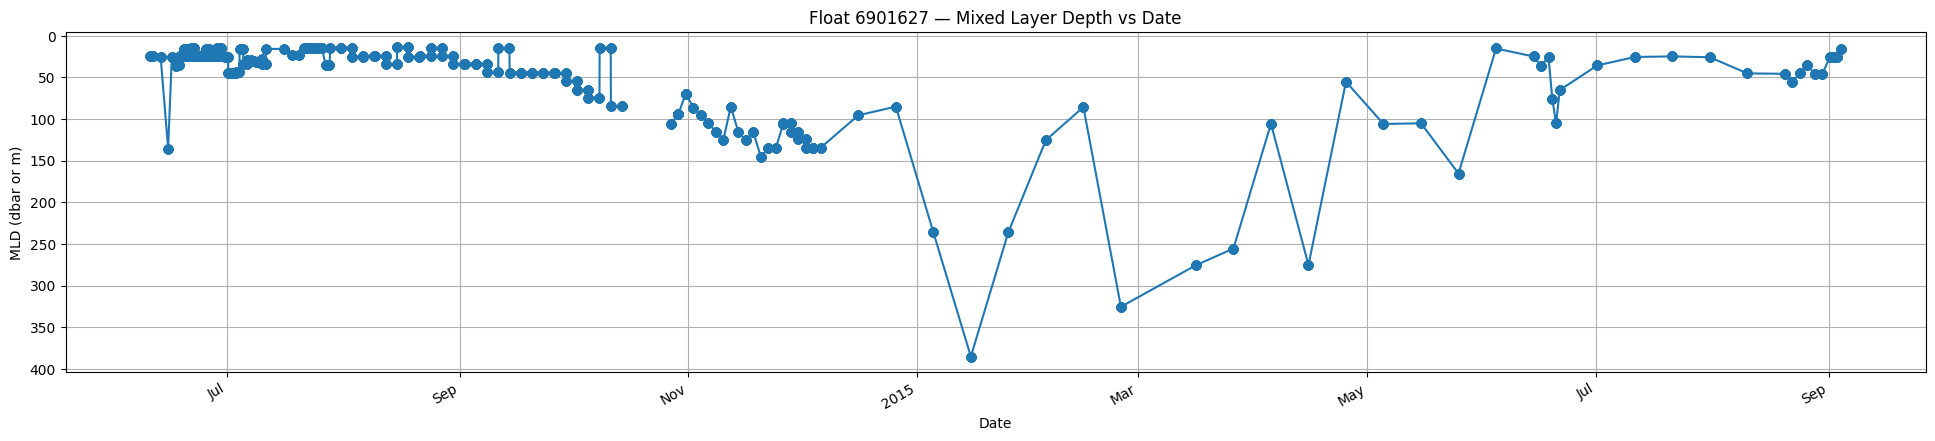

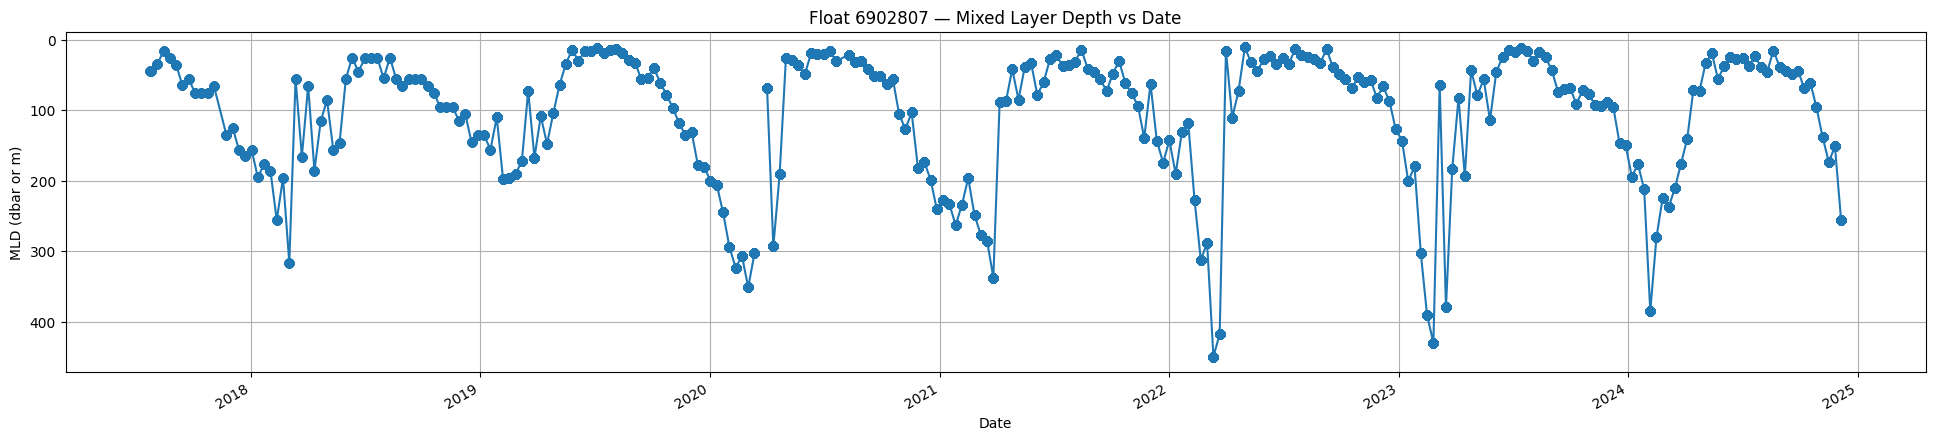

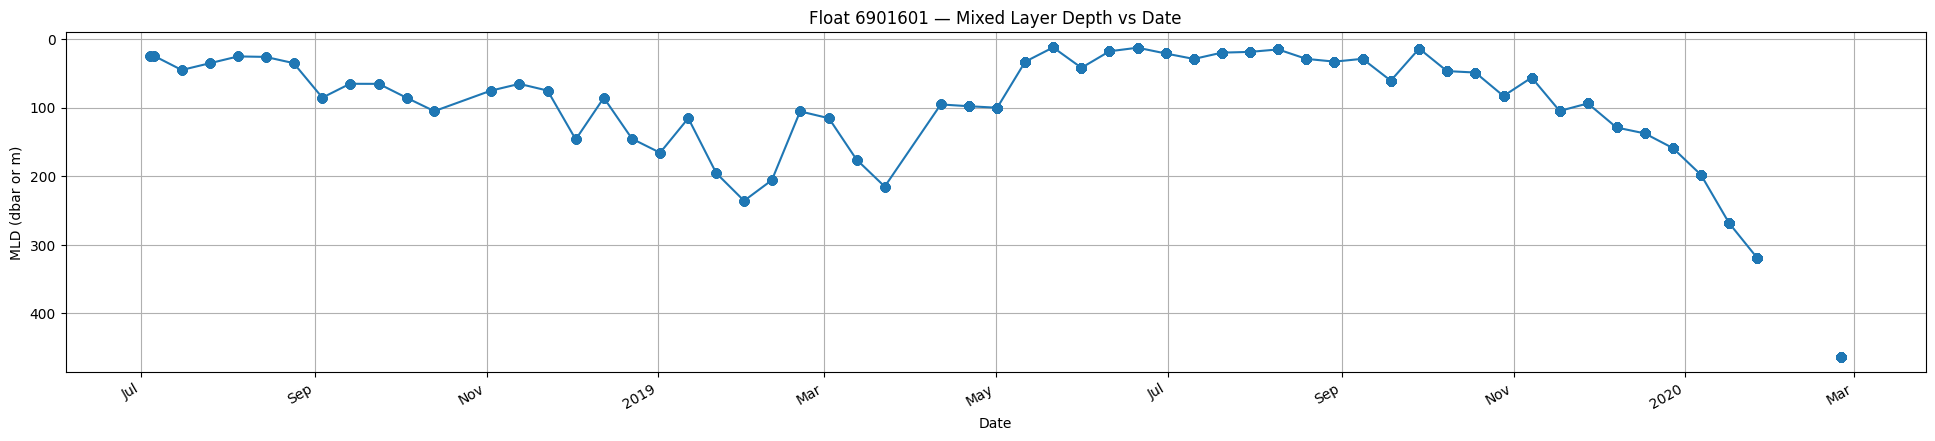

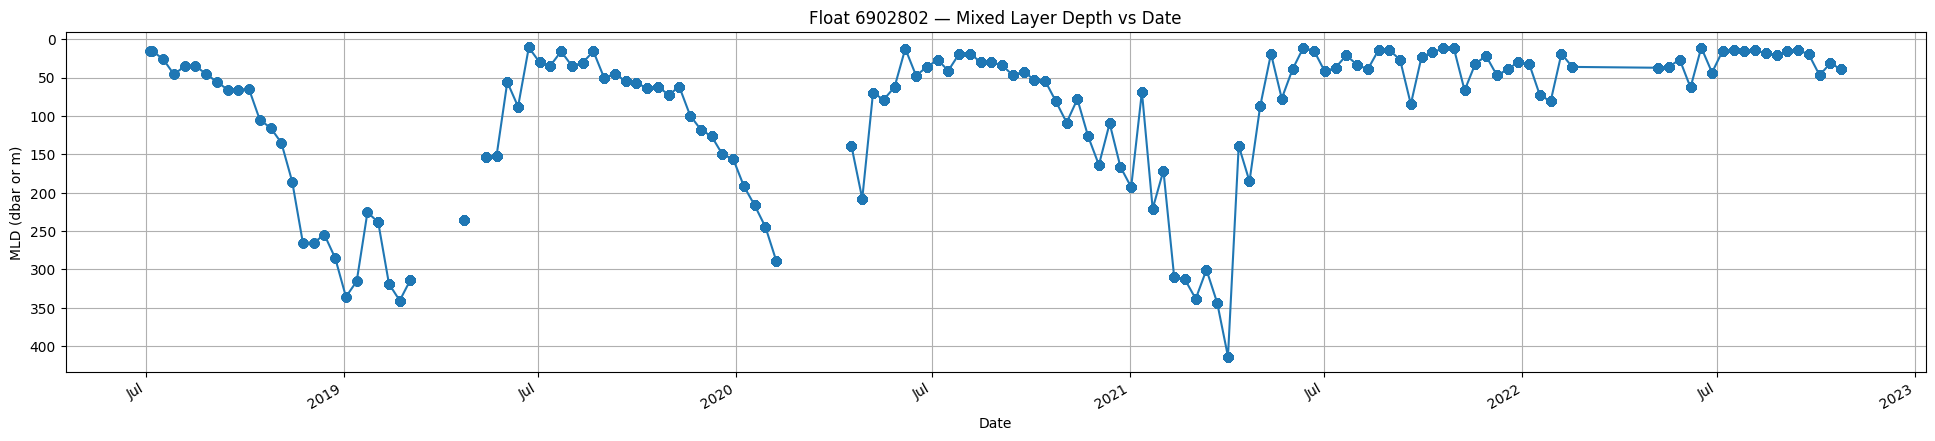

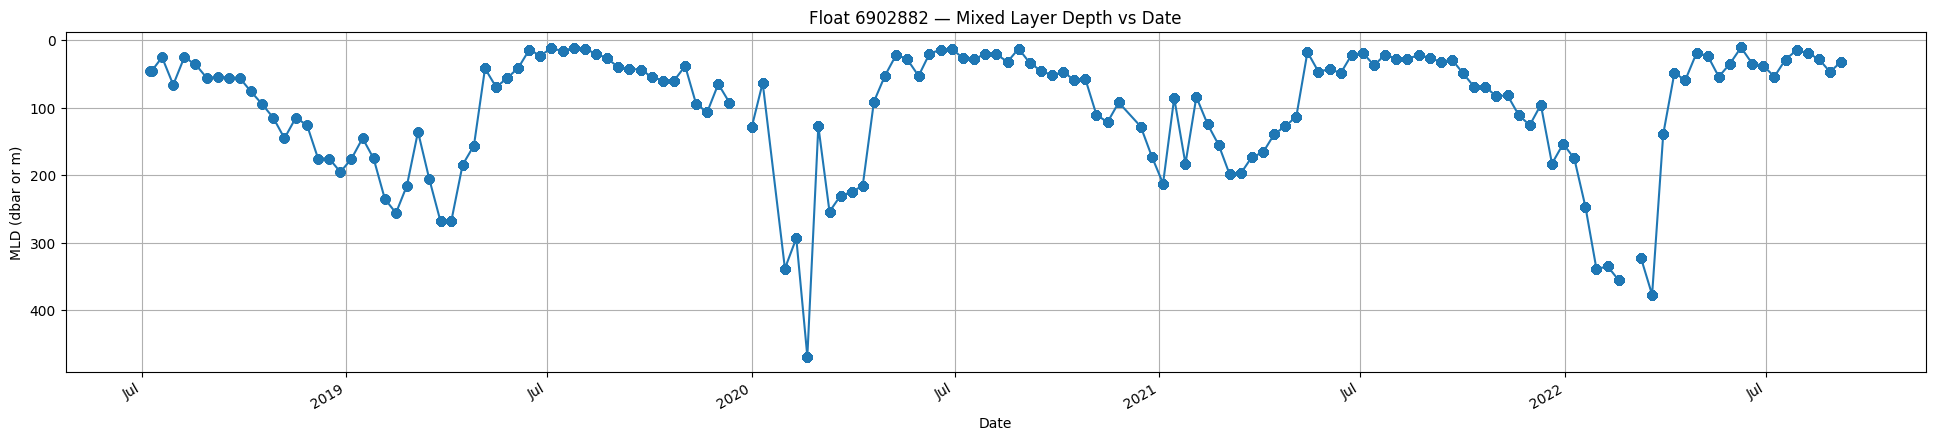

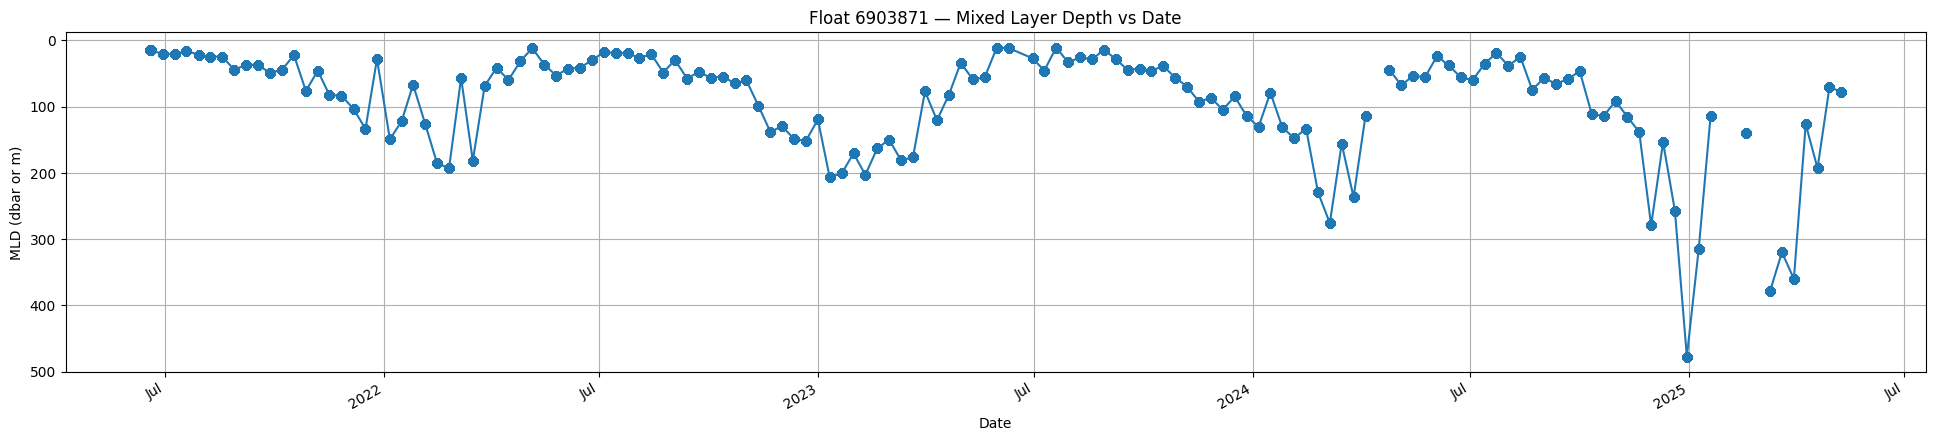

In [ ]:
pd_df = df.to_pandas()

# Make sure your date column is a proper datetime
# Example: if your column is 'JULD', convert like:
pd_df['TIME'] = pd.to_datetime(pd_df['TIME'])

# Filter by each float and plot
for fid in pd_df['PLATFORM_NUMBER'].unique():
    sub = pd_df[pd_df['PLATFORM_NUMBER'] == fid]
    # Summarise one MLD per cycle (assuming one MLD per cycle)
    summary = sub.groupby('CYCLE_NUMBER').agg({
        'TIME': 'first',   # or maybe 'min' or 'max' depending
        'MLD': 'first'
    }).reset_index()

    fig, ax = plt.subplots(figsize=(24,5))
    ax.plot(sub['TIME'], sub["MLD"],
            marker="o", label=f"Float {float_id}")
    ax.set_title(f"Float {fid} — Mixed Layer Depth vs Date")
    ax.set_xlabel("Date")
    ax.set_ylabel("MLD (dbar or m)")
    ax.invert_yaxis()  # deeper depth = larger number → put deeper downwards
    # Format the x-axis as dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.autofmt_xdate()
    plt.grid(True)
    plt.show()

# Expanded Dataset
Analysis and parameters were developed based on studies Tanner et al. (2024) Shoeman, Erbe & McCauley 2024

# Download Expanded dataset
Here we download all profiles within region since 2014. Download are stored as Regional_Argo_Tablet.parquet. 

In [ ]:

from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

# Pacakages for data handling
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
import polars as pl
import os
from pathlib import Path
from shapely.geometry import Point, Polygon
xr.set_options(display_expand_attrs = False)

In [ ]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

### Define an ocean region to work with

For this demo notebook, we'll work with BGC floats in the Labrador Sea

For your own use, you can simply overwrite the ``BOX`` variable content with your region.

In [ ]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
BOX = [-44, -10, 55, 67, 0, 3000, '2012-08', '2025-08']

### Get more info about this region using the ArgoIndex

In [ ]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (368332 records)
Searched: False

In [ ]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure axis BOX limits
idx = idx.query.box(index_BOX) # Had to replace this with something new as argopy has been updated

In [ ]:
# Get the list of all parameters for this region:
idx.read_params()

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY_2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [ ]:
# Extract the list of BGC parameters:
bgc_params = idx.read_params()
#[bgc_params.remove(p) for p in ['PH_IN_SITU_TOTAL', 'BISULFIDE', 'CDOM']]  # Remove core variables from the list
bgc_params

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY_2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [ ]:
# How many different floats in the region:
len(idx.read_wmo())

128

### Load all Physical data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [ ]:
%%time

# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='phy', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

In [ ]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 10GB
Dimensions:                   (N_POINTS: 9048856)
Coordinates:
    LATITUDE                  (N_POINTS) float64 72MB 59.82 59.82 ... 60.97
    LONGITUDE                 (N_POINTS) float64 72MB -36.93 -36.93 ... -17.64
    TIME                      (N_POINTS) datetime64[ns] 72MB 2012-08-01T04:37...
  * N_POINTS                  (N_POINTS) int64 72MB 0 1 2 ... 9048854 9048855
Data variables: (12/23)
    CONFIG_MISSION_NUMBER     (N_POINTS) int64 72MB 1 1 1 1 1 1 ... 4 4 4 4 4 4
    CYCLE_NUMBER              (N_POINTS) int64 72MB 311 311 311 311 ... 77 77 77
    DATA_MODE                 (N_POINTS) <U1 36MB 'D' 'D' 'D' ... 'A' 'A' 'A'
    DIRECTION                 (N_POINTS) <U1 36MB 'A' 'A' 'A' ... 'A' 'A' 'A'
    PLATFORM_NUMBER           (N_POINTS) int64 72MB 4901404 4901404 ... 1902621
    POSITION_QC               (N_POINTS) int64 72MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    ...                        ...
    TEMP_ADJUSTED             (N_POINTS) float32 36MB 11.01 11.01 ... 2.621
    TEMP_ADJUSTED_ERROR       (N_POINTS) float32 36MB 0.002 0.002 ... 0.002
    TEMP_ADJUSTED_QC          (N_POINTS) int64 72MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    TEMP_QC                   (N_POINTS) int64 72MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    TIME_QC                   (N_POINTS) int64 72MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    VERTICAL_SAMPLING_SCHEME  (N_POINTS) <U246 9GB '' ... 'Primary sampling: ...
Attributes: (7)

In [ ]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(9048856) ~ N_PROF(31137) x N_LEVELS(3989)

In [ ]:
variables = ['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'TEMP', 'PSAL', 'PSAL_QC', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC']
df = pl.DataFrame(ds.to_dataframe()) 

Had to change directoy stuff


In [ ]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/Region/'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'Region' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

In [ ]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,date,latitude,longitude,wmo,cyc
0,2023-07-03 15:05:00,59.562168,-38.311313,7901037,1
1,2023-07-04 16:25:00,59.757223,-40.911627,7901036,1
2,2025-04-02 01:34:00,66.989793,-24.404108,6990657,13
3,2024-06-28 12:57:59,60.078591,-20.071637,6990636,12
4,2024-06-25 00:47:22,60.153341,-21.595969,6990636,11
...,...,...,...,...,...
31132,2025-06-19 11:40:58,61.793573,-29.307393,7902223,39
31133,2025-06-29 11:40:58,61.840967,-28.672233,7902223,40
31134,2025-07-09 11:42:58,62.354914,-28.088273,7902223,41
31135,2025-07-19 11:39:28,63.368121,-27.901616,7902223,42


In [ ]:
df = pl.read_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns]
1,311,"""D""","""A""",4901404,1,2.5,2.5,2.4,1,1,34.861,34.860989,0.01,1,1,11.005,11.005,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14
1,311,"""D""","""A""",4901404,1,4.0,4.0,2.4,1,1,34.861,34.860958,0.01,1,1,11.005,11.005,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14
1,311,"""D""","""A""",4901404,1,6.0,6.0,2.4,1,1,34.861,34.861019,0.01,1,1,11.006,11.006,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14
1,311,"""D""","""A""",4901404,1,8.0,8.0,2.4,1,1,34.861,34.861382,0.01001,1,1,11.006,11.006,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14
1,311,"""D""","""A""",4901404,1,10.0,10.0,2.4,1,1,34.860001,34.860222,0.01,1,1,10.997,10.997,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14


### Load all BGC data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [ ]:
BOX = [-44, -10, 55, 67, 0, 2000, '2010-08', '2025-08']

In [ ]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='bgc', mode='expert', params = 'all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...
CPU times: user 32min 38s, sys: 3min 35s, total: 36min 14s
Wall time: 54min 38s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo BGC data fetcher for a space/time region
🗺  Domain: [x=-44.00/-10.00; y=55.00/67.00; z=0.0/2000.0; t=2010-08-01/2025-08-01]
🔗 API: https://erddap.ifremer.fr/erddap
📗 Parameters: ['BBP532', 'BBP700', 'BISULFIDE', 'CDOM', 'CHLA', 'CP660', 'DOWNWELLING_PAR', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE412', 'DOWN_IRRADIANCE490', 'DOXY', 'NITRATE', 'PH_IN_SITU_TOTAL', 'PRES', 'PSAL', 'TEMP']
📕 BGC 'must be measured' parameters: []
🏄 User mode: expert
🟢 Dataset: bgc-s
🌤  Performances: cache=False, parallel=True [thread]

In [ ]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 4GB
Dimensions:                            (N_POINTS: 7000323)
Coordinates:
    LATITUDE                           (N_POINTS) float64 56MB 56.39 ... 61.05
    LONGITUDE                          (N_POINTS) float64 56MB -29.82 ... -26.33
    TIME                               (N_POINTS) datetime64[ns] 56MB 2010-08...
  * N_POINTS                           (N_POINTS) int64 56MB 0 1 ... 7000322
Data variables: (12/102)
    BBP532                             (N_POINTS) float32 28MB nan nan ... nan
    BBP532_ADJUSTED                    (N_POINTS) float32 28MB nan nan ... nan
    BBP532_ADJUSTED_ERROR              (N_POINTS) float32 28MB nan nan ... nan
    BBP532_ADJUSTED_QC                 (N_POINTS) int64 56MB 99999 ... 99999
    BBP532_DATA_MODE                   (N_POINTS) <U1 28MB '' '' '' ... '' '' ''
    BBP532_QC                          (N_POINTS) int64 56MB 99999 ... 99999
    ...                                 ...
    TEMP_ADJUSTED                      (N_POINTS) float32 28MB nan nan ... 3.802
    TEMP_ADJUSTED_ERROR                (N_POINTS) float32 28MB nan nan ... nan
    TEMP_ADJUSTED_QC                   (N_POINTS) int64 56MB 4 4 1 1 ... 8 8 8 1
    TEMP_DATA_MODE                     (N_POINTS) <U1 28MB 'D' 'D' ... 'R' 'R'
    TEMP_QC                            (N_POINTS) int64 56MB 3 1 1 1 ... 8 1 8 1
    TIME_QC                            (N_POINTS) int64 56MB 1 1 1 1 ... 1 1 1 1
Attributes: (7)

In [ ]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(7000323) ~ N_PROF(9650) x N_LEVELS(4694)

In [ ]:
variables = ['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'TEMP', 'PSAL', 'PSAL_QC', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC']
df = pl.DataFrame(ds.to_dataframe()) 

Had to change directoy stuff


In [ ]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/Region/'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'Region' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet_s.parquet')

In [ ]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,file,date,latitude,longitude,ocean,profiler_code,institution_code,parameters,parameter_data_mode,date_update,wmo,cyc,institution,dac,profiler
0,aoml/1902304/profiles/SD1902304_157.nc,2024-03-21 21:21:39,55.297,-18.833,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDDAAARDD,2025-08-28 01:31:37,1902304,157,"AOML, USA",aoml,NAVIS_EBR
1,aoml/1902304/profiles/SD1902304_158.nc,2024-03-31 21:31:53,55.727,-18.865,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDDAAARDD,2025-08-28 01:31:48,1902304,158,"AOML, USA",aoml,NAVIS_EBR
2,aoml/1902304/profiles/SD1902304_159.nc,2024-04-10 21:11:20,56.325,-18.987,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDDAAARDD,2025-08-28 01:31:59,1902304,159,"AOML, USA",aoml,NAVIS_EBR
3,aoml/1902304/profiles/SD1902304_160.nc,2024-04-20 21:24:52,56.290,-18.758,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDDAAARDD,2025-08-28 01:32:10,1902304,160,"AOML, USA",aoml,NAVIS_EBR
4,aoml/1902304/profiles/SD1902304_161.nc,2024-04-30 21:30:20,56.509,-18.912,A,869,AO,PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...,DDDDAAARDD,2025-08-28 01:32:21,1902304,161,"AOML, USA",aoml,NAVIS_EBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9605,meds/4902580/profiles/SR4902580_056.nc,2023-11-28 17:19:00,55.490,-39.993,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:26:57,4902580,56,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor
9606,meds/4902580/profiles/SR4902580_057.nc,2023-12-08 22:14:00,55.595,-39.787,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:27:08,4902580,57,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor
9607,meds/4902580/profiles/SR4902580_058.nc,2023-12-19 03:17:00,55.784,-39.845,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:27:21,4902580,58,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor
9608,meds/4902580/profiles/SR4902580_059.nc,2023-12-29 08:11:00,55.797,-38.772,A,844,ME,PRES TEMP PSAL DOXY,RRRR,2025-08-28 14:27:32,4902580,59,"MEDS, Canada",meds,ARVOR float with SBE conductivity sensor


In [ ]:
df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet_s.parquet')

df.head()

BBP532,BBP532_ADJUSTED,BBP532_ADJUSTED_ERROR,BBP532_ADJUSTED_QC,BBP532_DATA_MODE,BBP532_QC,BBP700,BBP700_ADJUSTED,BBP700_ADJUSTED_ERROR,BBP700_ADJUSTED_QC,BBP700_DATA_MODE,BBP700_QC,BISULFIDE,BISULFIDE_ADJUSTED,BISULFIDE_ADJUSTED_ERROR,BISULFIDE_ADJUSTED_QC,BISULFIDE_DATA_MODE,BISULFIDE_QC,CDOM,CDOM_ADJUSTED,CDOM_ADJUSTED_ERROR,CDOM_ADJUSTED_QC,CDOM_DATA_MODE,CDOM_QC,CHLA,CHLA_ADJUSTED,CHLA_ADJUSTED_ERROR,CHLA_ADJUSTED_QC,CHLA_DATA_MODE,CHLA_QC,CONFIG_MISSION_NUMBER,CP660,CP660_ADJUSTED,CP660_ADJUSTED_ERROR,CP660_ADJUSTED_QC,CP660_DATA_MODE,CP660_QC,…,DOXY_QC,NITRATE,NITRATE_ADJUSTED,NITRATE_ADJUSTED_ERROR,NITRATE_ADJUSTED_QC,NITRATE_DATA_MODE,NITRATE_QC,PH_IN_SITU_TOTAL,PH_IN_SITU_TOTAL_ADJUSTED,PH_IN_SITU_TOTAL_ADJUSTED_ERROR,PH_IN_SITU_TOTAL_ADJUSTED_QC,PH_IN_SITU_TOTAL_DATA_MODE,PH_IN_SITU_TOTAL_QC,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_DATA_MODE,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_DATA_MODE,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_DATA_MODE,TEMP_QC,TIME_QC,LATITUDE,LONGITUDE,TIME
f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f32,f32,f32,i64,str,i64,…,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f64,f64,datetime[ns]
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,0.0,0.0,2.4,1,"""D""",1,34.801998,null,null,4,"""D""",3,12.661,null,null,4,"""D""",3,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,6.0,6.0,2.4,1,"""D""",1,34.806999,null,null,4,"""D""",3,12.664,null,null,4,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,17.0,17.0,2.4,1,"""D""",1,34.806999,34.806999,0.01,1,"""D""",1,12.666,12.666,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,26.0,26.0,2.4,1,"""D""",1,34.807999,34.807999,0.01,1,"""D""",1,12.662,12.662,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,36.0,36.0,2.4,1,"""D""",1,34.814999,34.814999,0.01,1,"""D""",1,12.633,12.633,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00


### Tagging By Float By Region

Creating polygons to produce a polygone mask to seperate dataset

In [ ]:
df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet_s.parquet')

df.head()

BBP532,BBP532_ADJUSTED,BBP532_ADJUSTED_ERROR,BBP532_ADJUSTED_QC,BBP532_DATA_MODE,BBP532_QC,BBP700,BBP700_ADJUSTED,BBP700_ADJUSTED_ERROR,BBP700_ADJUSTED_QC,BBP700_DATA_MODE,BBP700_QC,BISULFIDE,BISULFIDE_ADJUSTED,BISULFIDE_ADJUSTED_ERROR,BISULFIDE_ADJUSTED_QC,BISULFIDE_DATA_MODE,BISULFIDE_QC,CDOM,CDOM_ADJUSTED,CDOM_ADJUSTED_ERROR,CDOM_ADJUSTED_QC,CDOM_DATA_MODE,CDOM_QC,CHLA,CHLA_ADJUSTED,CHLA_ADJUSTED_ERROR,CHLA_ADJUSTED_QC,CHLA_DATA_MODE,CHLA_QC,CONFIG_MISSION_NUMBER,CP660,CP660_ADJUSTED,CP660_ADJUSTED_ERROR,CP660_ADJUSTED_QC,CP660_DATA_MODE,CP660_QC,…,DOXY_QC,NITRATE,NITRATE_ADJUSTED,NITRATE_ADJUSTED_ERROR,NITRATE_ADJUSTED_QC,NITRATE_DATA_MODE,NITRATE_QC,PH_IN_SITU_TOTAL,PH_IN_SITU_TOTAL_ADJUSTED,PH_IN_SITU_TOTAL_ADJUSTED_ERROR,PH_IN_SITU_TOTAL_ADJUSTED_QC,PH_IN_SITU_TOTAL_DATA_MODE,PH_IN_SITU_TOTAL_QC,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_DATA_MODE,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_DATA_MODE,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_DATA_MODE,TEMP_QC,TIME_QC,LATITUDE,LONGITUDE,TIME
f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f32,f32,f32,i64,str,i64,…,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f64,f64,datetime[ns]
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,0.0,0.0,2.4,1,"""D""",1,34.801998,null,null,4,"""D""",3,12.661,null,null,4,"""D""",3,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,6.0,6.0,2.4,1,"""D""",1,34.806999,null,null,4,"""D""",3,12.664,null,null,4,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,17.0,17.0,2.4,1,"""D""",1,34.806999,34.806999,0.01,1,"""D""",1,12.666,12.666,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,26.0,26.0,2.4,1,"""D""",1,34.807999,34.807999,0.01,1,"""D""",1,12.662,12.662,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00
null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,2,null,null,null,99999,"""""",99999,…,3,null,null,null,99999,"""""",99999,null,null,null,99999,"""""",99999,5902302,1,36.0,36.0,2.4,1,"""D""",1,34.814999,34.814999,0.01,1,"""D""",1,12.633,12.633,0.002,1,"""D""",1,1,56.387,-29.825,2010-08-05 04:35:00


In [ ]:
# -*- coding: utf-8 -*-
"""
Apply two custom geographic regions to parquet datasets using exact polygons.
Adds a 'region' column with values:
    'irminger', 'icelandic', or 'Other'
"""

from pathlib import Path
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon


# -------------------------------------------------------
# REGION POLYGONS (EXACT SHAPES)
# -------------------------------------------------------

irminger_vertices = [
    (-44, 66),
    (-25, 66),
    (-25, 64),
    (-35, 55),
    (-44, 55)
]
irminger_poly = Polygon(irminger_vertices)

# Vertices in (lon, lat) order
icelandic_vertices = [
    (-25, 64),   # 1
    (-10, 64),   # 2
    (-20, 55),   # 3
    (-35, 55)   # 4
]
icelandic_poly = Polygon(icelandic_vertices)


# -------------------------------------------------------
# GLOBAL CONFIG
# -------------------------------------------------------

USE_DEEP_OCEAN_MASK = False
ETOPO1_PATH = Path("../data/etopo1_subset.nc")

PARQUETS = [
    Path("../data/argo/Region/Regional_Argo_Tablet.parquet"),
    Path("../data/argo/Region/Regional_BGC-Argo_Tablet.parquet"),
]

COL_LON = "LONGITUDE"
COL_LAT = "LATITUDE"

OVERLAP_PRECEDENCE = "shape2_over_shape1"   # icelandic overrides irminger


# -------------------------------------------------------
# HELPERS
# -------------------------------------------------------

def to_minus180_180(lon):
    lon = np.asarray(lon, dtype=float)
    return ((lon + 180.0) % 360.0) - 180.0


def load_etopo(path):
    import xarray as xr
    if not path.exists():
        print(f"[WARN] ETOPO file not found at {path}. Deep-ocean mask skipped.")
        return None
    ds = xr.open_dataset(path)
    for k in ("z", "longitude", "latitude"):
        if k not in ds:
            raise ValueError("ETOPO dataset must include variables: z, longitude, latitude")
    return ds


def deep_mask_from_etopo(ds, lonp, latp, thresh=-1000.0):
    zi = ds["z"].interp(longitude=(["p"], lonp), latitude=(["p"], latp)).values
    return zi <= float(thresh)


# -------------------------------------------------------
# POLYGON-BASED SHAPE CLASSIFICATION
# -------------------------------------------------------

def classify_shapes(lonp, latp):
    points = [Point(lonp[i], latp[i]) for i in range(len(lonp))]

    in_irminger  = np.array([irminger_poly.contains(pt) for pt in points])
    in_icelandic = np.array([icelandic_poly.contains(pt) for pt in points])

    debug = {
        "irminger_vertices": irminger_vertices,
        "icelandic_vertices": icelandic_vertices,
        "irminger_count": int(in_irminger.sum()),
        "icelandic_count": int(in_icelandic.sum()),
    }

    return in_irminger, in_icelandic, debug


# -------------------------------------------------------
# LABEL ASSIGNMENT (IRINGER / ICELANDIC / OTHER)
# -------------------------------------------------------

def assign_labels(in1, in2, precedence="icelandic_over_irminger"):
    labels = np.full(len(in1), "Other", dtype=object)

    if precedence == "icelandic_over_irminger":
        labels[in1] = "irminger"
        labels[in2] = "icelandic"    # overrides overlaps
    else:
        labels[in2] = "icelandic"
        labels[in1] = "irminger"

    return labels


# -------------------------------------------------------
# PROCESS ONE PARQUET
# -------------------------------------------------------

def process_one(parquet_path, ds_etopo=None, use_deep=False):
    print(f"\n======== Processing: {parquet_path.name} ========")

    if not parquet_path.exists():
        print(f"[WARN] Missing parquet: {parquet_path} (skipped)")
        return

    df = pd.read_parquet(parquet_path).copy()

    if COL_LON not in df or COL_LAT not in df:
        raise KeyError(f"Expected columns '{COL_LON}' and '{COL_LAT}' in {parquet_path}")

    LON_raw = df[COL_LON].astype(float).to_numpy()
    LAT     = df[COL_LAT].astype(float).to_numpy()
    LON     = to_minus180_180(LON_raw)

    print(f"Lon raw range: {np.nanmin(LON_raw):.3f} → {np.nanmax(LON_raw):.3f}")
    print(f"Lon norm range: {np.nanmin(LON):.3f} → {np.nanmax(LON):.3f}")
    print(f"Lat range:      {np.nanmin(LAT):.3f} → {np.nanmax(LAT):.3f}")
    print(f"N rows:         {len(df)}")

    # Polygon classification
    in_irminger, in_icelandic, dbg = classify_shapes(LON, LAT)

    print("\n-- Irminger region --")
    print("Vertices:", dbg["irminger_vertices"])
    print("Points in region:", dbg["irminger_count"])

    print("\n-- Icelandic region --")
    print("Vertices:", dbg["icelandic_vertices"])
    print("Points in region:", dbg["icelandic_count"])

    # Deep-ocean mask
    if use_deep:
        if ds_etopo is None:
            raise RuntimeError("USE_DEEP_OCEAN_MASK=True but no ETOPO dataset loaded.")
        deep = deep_mask_from_etopo(ds_etopo, LON, LAT, thresh=-1000.0)
        in_irminger &= deep
        in_icelandic &= deep

    # Assign region names
    labels = assign_labels(in_irminger, in_icelandic, precedence=OVERLAP_PRECEDENCE)
    df["region"] = labels

    # Save result
    df.to_parquet(parquet_path, index=False)
    print("\nWrote:", parquet_path)
    print("Region counts:\n", df["region"].value_counts(dropna=False).to_string())


# -------------------------------------------------------
# MAIN
# -------------------------------------------------------

def main():
    ds = load_etopo(ETOPO1_PATH) if USE_DEEP_OCEAN_MASK else None
    for pq in PARQUETS:
        process_one(pq, ds_etopo=ds, use_deep=USE_DEEP_OCEAN_MASK)

if __name__ == "__main__":
    main()


======== Processing: Regional_Argo_Tablet.parquet ========
Lon raw range: -44.000 → -10.002
Lon norm range: -44.000 → -10.002
Lat range:      55.001 → 66.999
N rows:         9048856

-- Irminger region --
Vertices: [(-44, 66), (-25, 66), (-25, 64), (-35, 55), (-44, 55)]
Points in region: 4908523

-- Icelandic region --
Vertices: [(-25, 64), (-10, 64), (-20, 55), (-35, 55)]
Points in region: 3446450

Wrote: ../data/argo/Region/Regional_Argo_Tablet.parquet
Region counts:
 region
irminger     4908523
icelandic    3446450
Other         693883

======== Processing: Regional_BGC-Argo_Tablet.parquet ========
Lon raw range: -43.995 → -10.004
Lon norm range: -43.995 → -10.004
Lat range:      55.003 → 66.981
N rows:         7000323

-- Irminger region --
Vertices: [(-44, 66), (-25, 66), (-25, 64), (-35, 55), (-44, 55)]
Points in region: 4105263

-- Icelandic region --
Vertices: [(-25, 64), (-10, 64), (-20, 55), (-35, 55)]
Points in region: 2743770

Wrote: ../data/argo/Region/Regional_BGC-Argo_T


===== Regional_Argo_Tablet.parquet =====
TIME range: 2012-08-01 04:37:14 → 2025-07-31 11:51:57


,region,year,month,profile_count
0,Other,2012,8,16
1,Other,2012,9,23
2,Other,2012,10,19
3,Other,2012,11,12
4,Other,2012,12,21
5,Other,2013,1,19
6,Other,2013,2,13
7,Other,2013,3,7
8,Other,2013,4,7
9,Other,2013,5,8


,region,year,week,profile_count
0,Other,2012,31,3
1,Other,2012,32,2
2,Other,2012,33,5
3,Other,2012,34,4
4,Other,2012,35,4
5,Other,2012,36,5
6,Other,2012,37,4
7,Other,2012,38,5
8,Other,2012,39,7
9,Other,2012,40,6


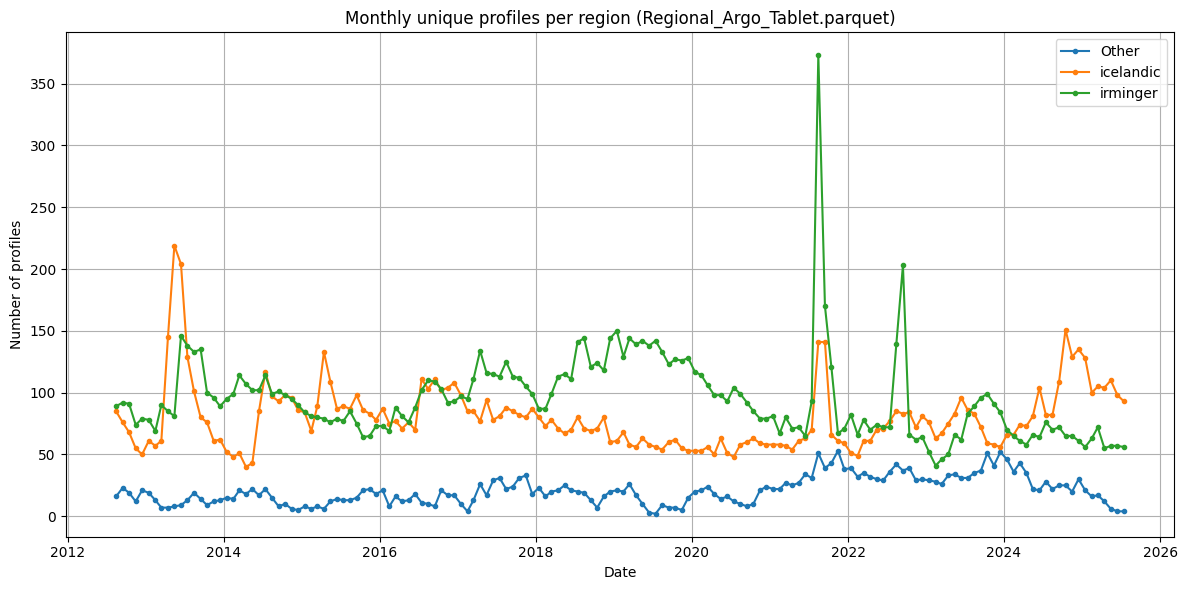

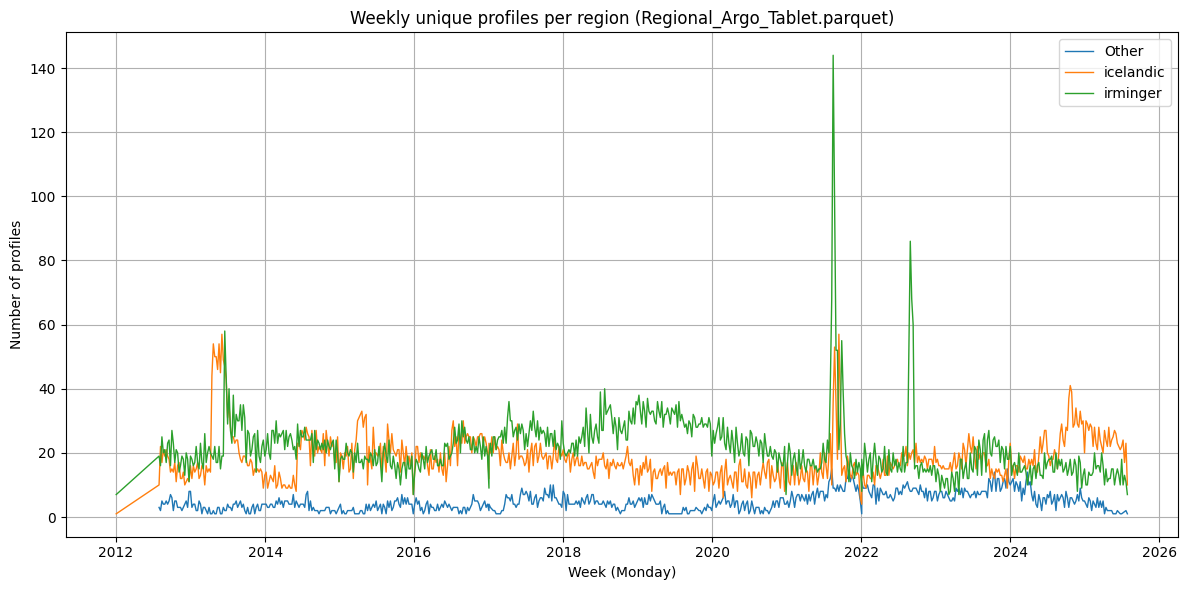

<Figure size 1200x600 with 0 Axes>

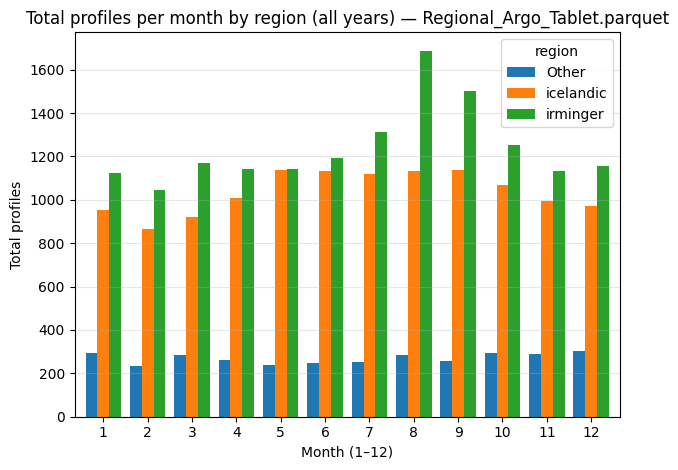

<Figure size 1200x600 with 0 Axes>

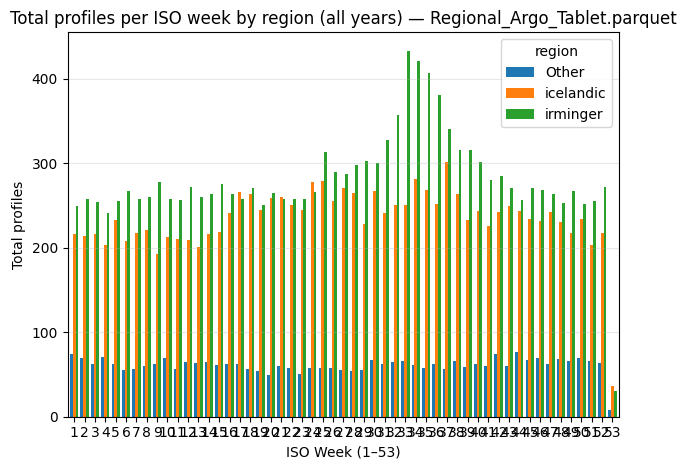


===== Regional_BGC-Argo_Tablet.parquet =====
TIME range: 2010-08-05 04:35:00 → 2025-07-31 11:51:57.020999936


,region,year,month,profile_count
0,Other,2013,3,2
1,Other,2013,5,1
2,Other,2013,6,4
3,Other,2013,7,4
4,Other,2013,8,2
5,Other,2013,9,3
6,Other,2013,10,1
7,Other,2013,11,3
8,Other,2013,12,3
9,Other,2014,1,2


,region,year,week,profile_count
0,Other,2013,10,1
1,Other,2013,11,1
2,Other,2013,20,1
3,Other,2013,22,1
4,Other,2013,24,1
5,Other,2013,25,1
6,Other,2013,26,1
7,Other,2013,27,1
8,Other,2013,28,1
9,Other,2013,29,1


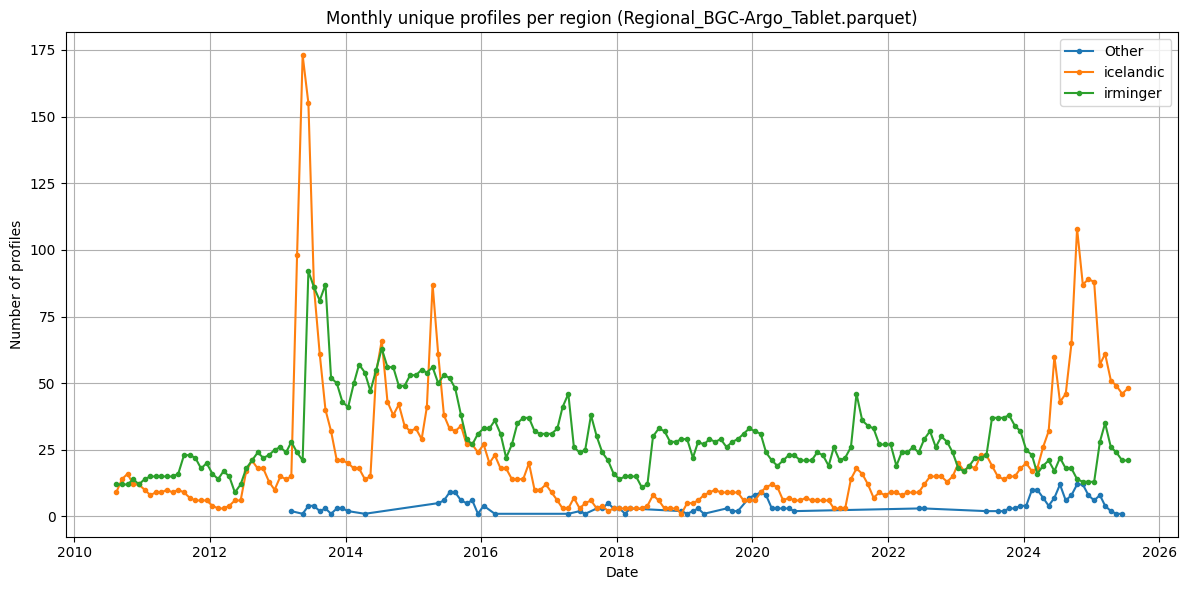

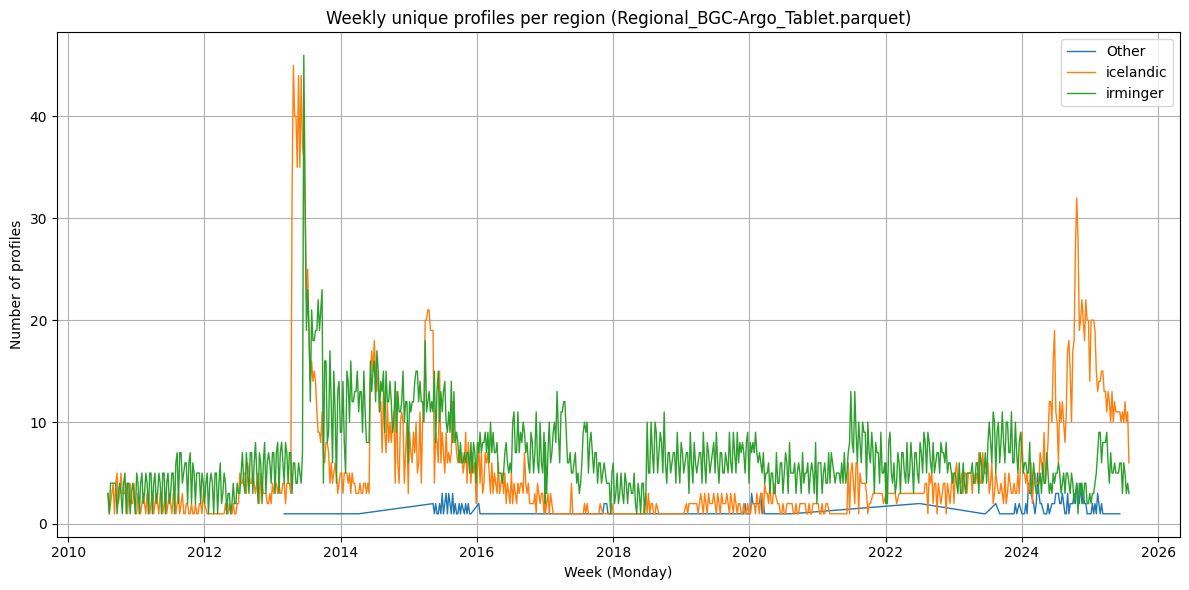

<Figure size 1200x600 with 0 Axes>

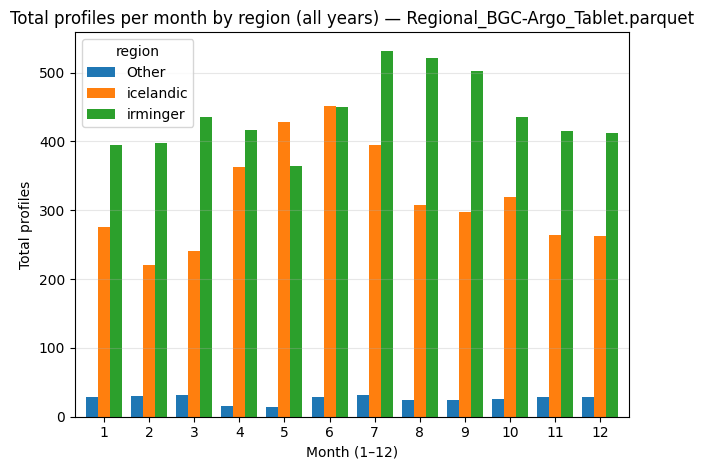

<Figure size 1200x600 with 0 Axes>

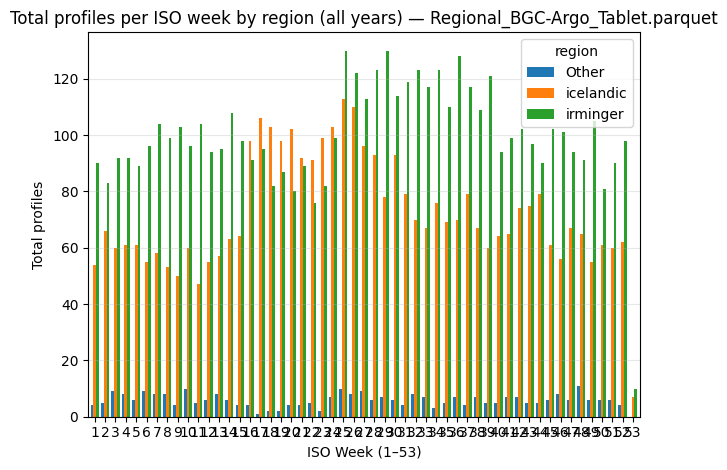

In [ ]:
# --- Quick check: number of unique profiles per region for BOTH datasets ---

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Files to analyze
parquets = [
    Path("../data/argo/Region/Regional_Argo_Tablet.parquet"),
    Path("../data/argo/Region/Regional_BGC-Argo_Tablet.parquet"),
]

# Columns (adjust if needed)
COL_TIME = "TIME"
COL_PLATFORM = "PLATFORM_NUMBER"
COL_CYCLE = "CYCLE_NUMBER"
COL_REGION = "region"

for parquet_path in parquets:
    print(f"\n===== {parquet_path.name} =====")
    df = pd.read_parquet(parquet_path)

    # --- Parse datetime ---
    df[COL_TIME] = pd.to_datetime(df[COL_TIME], errors="coerce", utc=True).dt.tz_convert(None)
    print("TIME range:", df[COL_TIME].min(), "→", df[COL_TIME].max())

    # --- Each (platform, cycle, region) = one profile ---
    profiles = df.drop_duplicates(subset=[COL_PLATFORM, COL_CYCLE, COL_REGION]).copy()

    # --- Extract year / month / ISO week ---
    profiles["year"] = profiles[COL_TIME].dt.year
    profiles["month"] = profiles[COL_TIME].dt.month
    profiles["week"] = profiles[COL_TIME].dt.isocalendar().week.astype(int)

    # --- Count profiles per region ---
    monthly_counts = (
        profiles.groupby(["region", "year", "month"], dropna=False)
        .size()
        .reset_index(name="profile_count")
        .sort_values(["region", "year", "month"])
    )

    weekly_counts = (
        profiles.groupby(["region", "year", "week"], dropna=False)
        .size()
        .reset_index(name="profile_count")
        .sort_values(["region", "year", "week"])
    )

    display(monthly_counts.head(10))
    display(weekly_counts.head(10))

    # --- Monthly plot ---
    plt.figure(figsize=(12, 6))
    for region, group in monthly_counts.groupby("region", dropna=False):
        # Plot at mid-month
        dates = pd.to_datetime(group["year"].astype(str) + "-" + group["month"].astype(str) + "-15")
        label = "NaN" if pd.isna(region) else region
        plt.plot(dates, group["profile_count"], marker="o", ms=3, label=label)
    plt.title(f"Monthly unique profiles per region ({parquet_path.name})")
    plt.xlabel("Date")
    plt.ylabel("Number of profiles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Weekly plot ---
    plt.figure(figsize=(12, 6))
    for region, group in weekly_counts.groupby("region", dropna=False):
        # Monday of the ISO week
        dates = pd.to_datetime(
            group["year"].astype(str) + "-W" + group["week"].astype(str) + "-1",
            format="%G-W%V-%u",
        )
        label = "NaN" if pd.isna(region) else region
        plt.plot(dates, group["profile_count"], linewidth=1, label=label)
    plt.title(f"Weekly unique profiles per region ({parquet_path.name})")
    plt.xlabel("Week (Monday)")
    plt.ylabel("Number of profiles")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()   
    
     # --- Total profiles per calendar month, broken down by region ---
    monthly_region_totals = (
        monthly_counts
        .groupby(["region", "month"])["profile_count"]
        .sum()
        .reset_index()
        .pivot(index="month", columns="region", values="profile_count")
        .fillna(0)
        .sort_index()
    )

    plt.figure(figsize=(12, 6))
    monthly_region_totals.plot(kind="bar", width=0.8)
    plt.title(f"Total profiles per month by region (all years) — {parquet_path.name}")
    plt.xlabel("Month (1–12)")
    plt.ylabel("Total profiles")
    plt.xticks(rotation=0)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

        # --- Total profiles per ISO week, broken down by region ---
    weekly_region_totals = (
        weekly_counts
        .groupby(["region", "week"])["profile_count"]
        .sum()
        .reset_index()
        .pivot(index="week", columns="region", values="profile_count")
        .fillna(0)
        .sort_index()
    )

    plt.figure(figsize=(12, 6))
    weekly_region_totals.plot(kind="bar", width=0.8)
    plt.title(f"Total profiles per ISO week by region (all years) — {parquet_path.name}")
    plt.xlabel("ISO Week (1–53)")
    plt.ylabel("Total profiles")
    plt.xticks(rotation=0)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


Plotting positions for: Regional_Argo_Tablet.parquet


/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:483: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packag

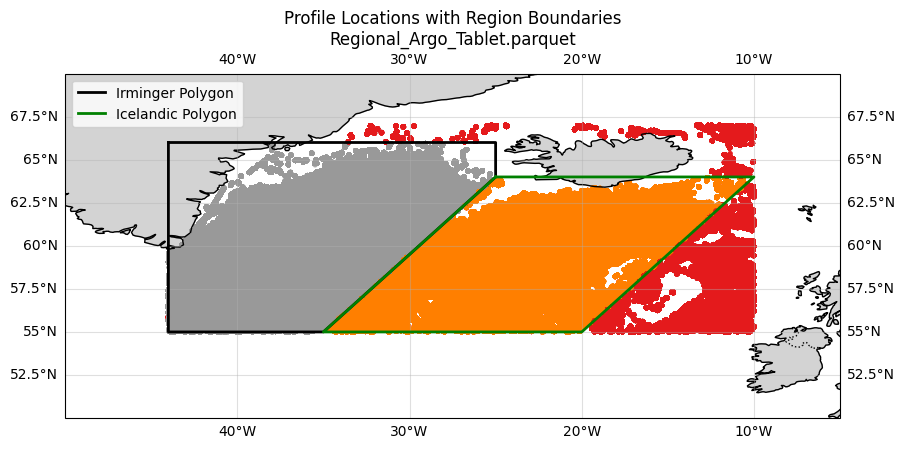


Plotting positions for: Regional_BGC-Argo_Tablet.parquet


/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:483: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packag

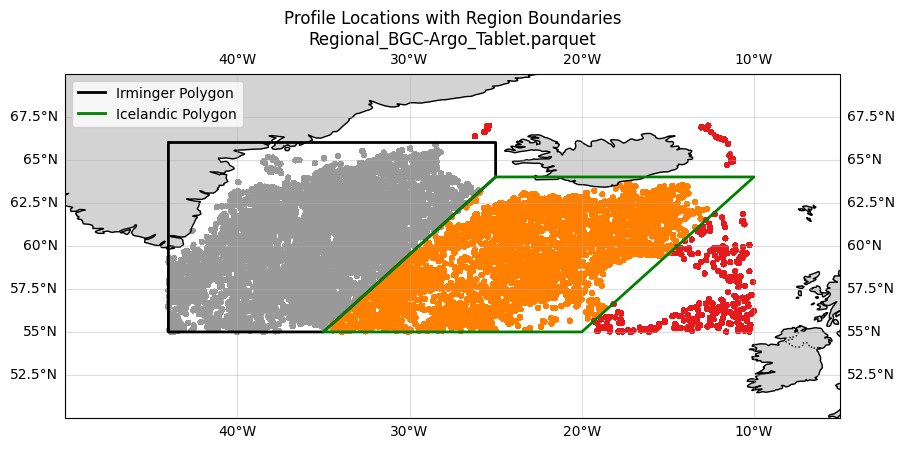

In [ ]:
# Plotting the location of the floats
# -------------------------------------------------------
# PLOT PROFILE LOCATIONS WITH REGION POLYGONS
# -------------------------------------------------------

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Reload DataFrame (already includes region labels)
for parquet_path in parquets:
    print(f"\nPlotting positions for: {parquet_path.name}")
    df = pd.read_parquet(parquet_path)

    # Normalise longitude
    lon = ((df["LONGITUDE"] + 180) % 360) - 180
    lat = df["LATITUDE"]

    # Setup figure
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Map extent (adjust if needed)
    ax.set_extent([-50, -5, 50, 70], crs=ccrs.PlateCarree())

    # Add base features
    ax.add_feature(cfeature.LAND, color="lightgray")
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.gridlines(draw_labels=True, alpha=0.4)

    # --- Plot the profile points ---
    scatter = ax.scatter(
        lon,
        lat,
        c=df["region"].astype("category").cat.codes,
        s=8,
        alpha=0.7,
        cmap="Set1",
        transform=ccrs.PlateCarree(),
    )

    # --- Plot the two polygons (region boundaries) ---
    irm_lons, irm_lats = zip(*irminger_vertices)
    ax.plot(irm_lons + (irm_lons[0],),
            irm_lats + (irm_lats[0],),
            "-k", lw=2, label="Irminger Polygon")

    ice_lons, ice_lats = zip(*icelandic_vertices)
    ax.plot(ice_lons + (ice_lons[0],),
            ice_lats + (ice_lats[0],),
            "-g", lw=2, label="Icelandic Polygon")

    # --- Legend ---
    plt.title(f"Profile location within Defined Regions.")
    plt.legend()
    plt.show()

# Argo Analysis

## Physical Parameters

MLD Was estiamted using gsw and Adjusted values. MLD time series was also developed, values were averaged weekly (atleast at first) 

In [148]:
import polars as pl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
import gsw



#### Producing MLD

In [149]:
# Defining Function

"""
  In site density Calculation Function.
Using Gibbs SeaWater (GSW) Oceanographic Toolbox, it is added as 
another column to the Polars DataFrame.
"""
def add_density(df: pl.DataFrame) -> pl.DataFrame:
    # Extract numpy arrays
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    # Compute absolute salinity, conservative temperature, density
    SA  = gsw.SA_from_SP(SP, p, lon, lat)
    CT  = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)

    # Append new column as a Polars Series
    return df.with_columns(pl.Series("RHO", rho))

# Creating potential density function (for MLD calculations)
def add_sigma0(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add potential density anomaly sigma0 [kg/m^3 - 1000] as a column 'SIGMA0'.
    Requires PSAL [PSS-78], TEMP [°C in-situ], PRES [dbar], LONGITUDE [degE], LATITUDE [degN].
    """
    SP  = df["PSAL_ADJUSTED"].to_numpy()
    t   = df["TEMP_ADJUSTED"].to_numpy()
    p   = df["PRES_ADJUSTED"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)  # kg/m^3 - 1000
    return df.with_columns(pl.Series("SIGMA0", sigma0))

# Creating Mixed Layer Depth function for MLD calculations
"""
 Calculation based on de Montety et al. (2014) definition:
"""
# Compute MLD per profile
def compute_mld_for_profile(pres: np.ndarray, sigma0: np.ndarray,
                            ref_depth: float = 10.0, drho_threshold: float = 0.03) -> float:
    sort_idx = np.argsort(pres)
    pres_sorted = pres[sort_idx]
    sigma0_sorted = sigma0[sort_idx]
    idx_ref = np.argmin(np.abs(pres_sorted - ref_depth))
    sigma0_ref = sigma0_sorted[idx_ref]
    sigma0_th = sigma0_ref + drho_threshold
    mask = sigma0_sorted >= sigma0_th
    mask[:(idx_ref+1)] = False
    if not np.any(mask):
        return np.nan
    idx_mld = np.where(mask)[0][0]
    return float(pres_sorted[idx_mld])





In [150]:
# Fetching data from Parquet.
df = pl.read_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

# Filtering data below 500m
#df = df.filter(pl.col('PRES') < 1000)

# EStimating MLD

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing MLD per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME,region,SIGMA0,MLD
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns],str,f64,f64
1,311,"""D""","""A""",4901404,1,2.5,2.5,2.4,1,1,34.861,34.860989,0.01,1,1,11.005,11.005,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14,"""irminger""",26.670154,18.0
1,311,"""D""","""A""",4901404,1,4.0,4.0,2.4,1,1,34.861,34.860958,0.01,1,1,11.005,11.005,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14,"""irminger""",26.670158,18.0
1,311,"""D""","""A""",4901404,1,6.0,6.0,2.4,1,1,34.861,34.861019,0.01,1,1,11.006,11.006,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14,"""irminger""",26.670062,18.0
1,311,"""D""","""A""",4901404,1,8.0,8.0,2.4,1,1,34.861,34.861382,0.01001,1,1,11.006,11.006,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14,"""irminger""",26.670382,18.0
1,311,"""D""","""A""",4901404,1,10.0,10.0,2.4,1,1,34.860001,34.860222,0.01,1,1,10.997,10.997,0.002,1,1,1,"""""",59.824,-36.926,2012-08-01 04:37:14,"""irminger""",26.671143,18.0


#### Creating Time MLD time series 
Time series was created by using weekly averages and linear interporlation for each Region

In [151]:

# --- Separating Regions ---
irminger = df.filter(pl.col('region') == 'irminger').to_pandas()
icelandic = df.filter(pl.col('region') == 'icelandic').to_pandas()

# --- One row per (platform, cycle) profile ---
irminger = irminger.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()
icelandic = icelandic.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()

# --- TIME to datetime ---
irminger["TIME"] = pd.to_datetime(irminger["TIME"])
icelandic["TIME"] = pd.to_datetime(icelandic["TIME"])

# --- ISO year/week ---
irminger["year"]     = irminger["TIME"].dt.isocalendar().year.astype(int)
irminger["iso_week"] = irminger["TIME"].dt.isocalendar().week.astype(int)
irminger["month"]    = irminger["TIME"].dt.month

icelandic["year"]     = icelandic["TIME"].dt.isocalendar().year.astype(int)
icelandic["iso_week"] = icelandic["TIME"].dt.isocalendar().week.astype(int)
icelandic["month"]    = icelandic["TIME"].dt.month

# --- Weekly mean + range (min/max) ---
weekly1 = (
    irminger.groupby(["year", "iso_week"])
          .agg(MLD_mean=("MLD", "mean"),
               MLD_min=("MLD", "min"),
               MLD_max=("MLD", "max"))
          .reset_index()
)
weekly2 = (
    icelandic.groupby(["year", "iso_week"])
          .agg(MLD_mean=("MLD", "mean"),
               MLD_min=("MLD", "min"),
               MLD_max=("MLD", "max"))
          .reset_index()
)

# --- Convert ISO year-week to a date (Monday of that ISO week) ---
def iso_to_date(df):
    dates = [dt.date.fromisocalendar(int(y), int(w), 1) for y, w in zip(df["year"], df["iso_week"])]
    df = df.assign(date=pd.to_datetime(dates)).sort_values("date")
    return df

weekly1 = iso_to_date(weekly1)
weekly2 = iso_to_date(weekly2)

# Optional: drop rows where stats are all NaN (e.g., empty weeks)
weekly1 = weekly1.dropna(subset=["MLD_mean", "MLD_min", "MLD_max"])
weekly2 = weekly2.dropna(subset=["MLD_mean", "MLD_min", "MLD_max"])


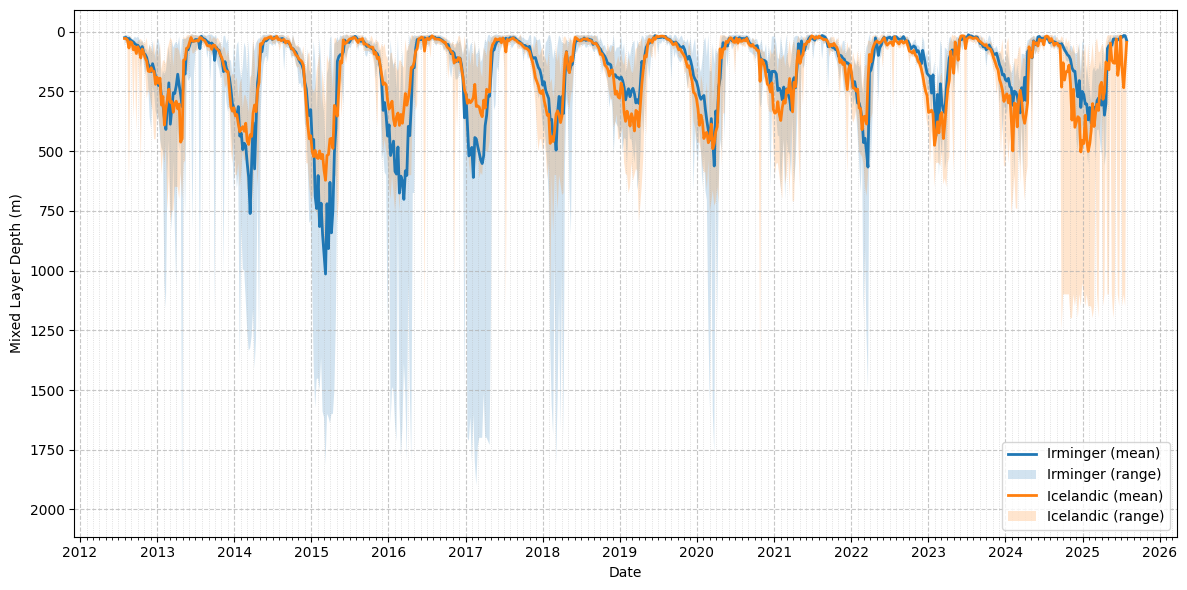

In [152]:
#Plotting 
fig, ax = plt.subplots(figsize=(12, 6))

# Irminger Mea
ax.plot(weekly1["date"], weekly1["MLD_mean"], label="Irminger (mean)", linewidth=2)
ax.fill_between(
    weekly1["date"],
    weekly1["MLD_min"],
    weekly1["MLD_max"],
    alpha=0.2,
    label="Irminger (range)"
)
# Icelandic 
ax.plot(weekly2["date"], weekly2["MLD_mean"], label="Icelandic (mean)", linewidth=2)
ax.fill_between(
    weekly2["date"],
    weekly2["MLD_min"],
    weekly2["MLD_max"],
    alpha=0.2,
    label="Icelandic (range)"
)
# Invert y-axis (MLD increases downward)
ax.invert_yaxis()

# Labels
ax.set_xlabel("Date")
ax.set_ylabel("Mixed Layer Depth (m)")

# Ticks: yearly majors, monthly minors
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_locator(MonthLocator())

# Grid
ax.grid(True, which="major", linestyle="--", linewidth=0.8, alpha=0.7)
ax.grid(True, which="minor", linestyle=":", linewidth=0.6, alpha=0.5)

# Legend
ax.legend()

fig.tight_layout()
plt.show()

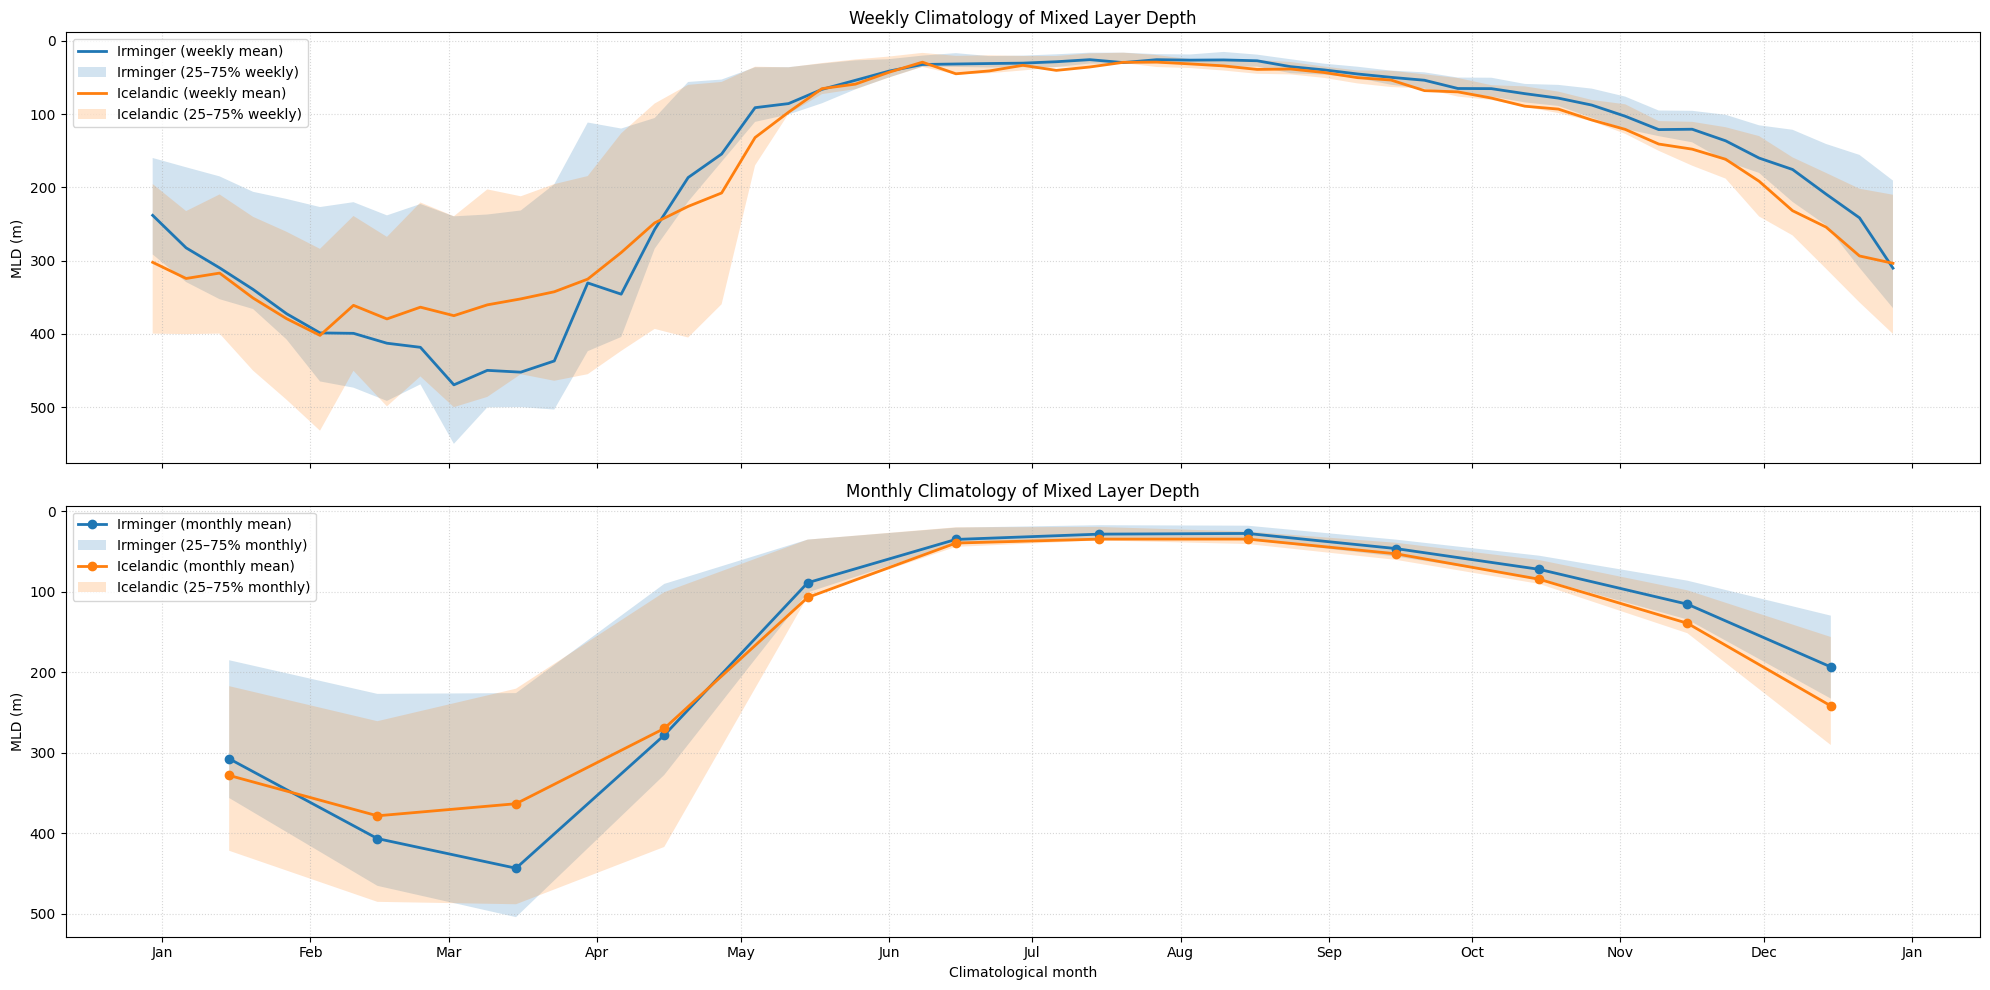

In [153]:
# Creataing MLD Climatology per region

# --- Climatological weekly stats (mean, 25-75% quartiles) ---
clim1 = (
    irminger.groupby("iso_week")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)

clim2 = (
    icelandic.groupby("iso_week")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)



def week_to_date(df):
    dates = [dt.date.fromisocalendar(2020, int(w), 1) for w in df["iso_week"]]
    df["date"] = pd.to_datetime(dates)
    return df

clim1 = week_to_date(clim1)
clim2 = week_to_date(clim2)

# Make sure you have a 'month' column (if not already created earlier)
irminger["month"] = irminger["TIME"].dt.month
icelandic["month"] = icelandic["TIME"].dt.month

# --- Climatological monthly stats (mean, 25-75% quartiles) ---
clim1_m = (
    irminger.groupby("month")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)

clim2_m = (
    icelandic.groupby("month")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)

# Create a fake "climatological" date for mid-month in 2020
clim1_m["date"] = pd.to_datetime(
    dict(year=2020, month=clim1_m["month"], day=15)
)
clim2_m["date"] = pd.to_datetime(
    dict(year=2020, month=clim2_m["month"], day=15)
)



# --- Plot weekly + monthly ---

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# ===== Weekly (top) =====
# Region 1
ax1.plot(clim1["date"], clim1["MLD_mean"], linewidth=2, label="Irminger (weekly mean)")
ax1.fill_between(clim1["date"], clim1["MLD_p25"], clim1["MLD_p75"],
                 alpha=0.2, label="Irminger (25–75% weekly)")

# Region 2
ax1.plot(clim2["date"], clim2["MLD_mean"], linewidth=2, label="Icelandic (weekly mean)")
ax1.fill_between(clim2["date"], clim2["MLD_p25"], clim2["MLD_p75"],
                 alpha=0.2, label="Icelandic (25–75% weekly)")

ax1.invert_yaxis()
ax1.set_ylabel("MLD (m)")
ax1.set_title("Weekly Climatology of Mixed Layer Depth")
ax1.grid(True, linestyle=":", alpha=0.5)
ax1.legend()

# ===== Monthly (bottom) =====
# Region 1
ax2.plot(clim1_m["date"], clim1_m["MLD_mean"], linewidth=2, marker="o",
         label="Irminger (monthly mean)")
ax2.fill_between(clim1_m["date"], clim1_m["MLD_p25"], clim1_m["MLD_p75"],
                 alpha=0.2, label="Irminger (25–75% monthly)")

# Region 2
ax2.plot(clim2_m["date"], clim2_m["MLD_mean"], linewidth=2, marker="o",
         label="Icelandic (monthly mean)")
ax2.fill_between(clim2_m["date"], clim2_m["MLD_p25"], clim2_m["MLD_p75"],
                 alpha=0.2, label="Icelandic (25–75% monthly)")

ax2.invert_yaxis()

# Shared x: month ticks
ax2.xaxis.set_major_locator(MonthLocator())
ax2.xaxis.set_major_formatter(DateFormatter("%b"))

ax2.set_xlabel("Climatological month")
ax2.set_ylabel("MLD (m)")
ax2.set_title("Monthly Climatology of Mixed Layer Depth")
ax2.grid(True, linestyle=":", alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

clim1_m.to_parquet('../data/argo/Region/irminger_MLD_Climatology.parquet', index=False)
clim2_m.to_parquet('../data/argo/Region/icelandic_MLD_Climatology.parquet', index=False)


## BGC-Chlorophyll Analysis
Here we conduct Analysis on BGC-CHLA analysis

In [182]:
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [183]:
df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')

# QC Filtering on CHLA_ADJUSTED data
df = df.filter(pl.col('CHLA_ADJUSTED_QC').is_in([1,2]))  # Keep only good and probably good data

# Filtering Negative and zero CHLA values
df = df.filter(pl.col('CHLA_ADJUSTED') > 0)

# Filtering Date after 2020-01-01
#df = df.filter(pl.col('TIME') > dt.datetime(2020, 1, 1))

# Adjusting CHLA values reducing by a a factor of 4
#df = df.with_columns(
#    (pl.col('CHLA_ADJUSTED') / 4).alias('CHLA_ADJUSTED')
#)

#Filtering out extreme CHLA values above 10 mg/m3
df = df.filter(
    pl.col("CHLA_ADJUSTED") <= 15
)

# Filtering Irminger and 2
df = df.filter(pl.col('region') != 'Other')

df.write_parquet('../data/argo/Region/Regional_BGC-Argo_CHLA_Tablet(filtered).parquet')

### Depth Integrating CHL-a

In [184]:
# Creating an integration function for CHLA

# Computing depth-integrated Chlorophyll per profile
def integrate_chl(df, chl_col="CHLA_ADJUSTED", pres_col="PRES_ADJUSTED"):
    """
    Compute depth-integrated chlorophyll per BGC-Argo profile using
    trapezoidal integration on CHLA_ADJUSTED vs PRES_ADJUSTED.

    Parameters
    ----------
    df : pl.DataFrame
        Must contain PLATFORM_NUMBER, CYCLE_NUMBER, CHLA_ADJUSTED, PRES_ADJUSTED
        and be pre-filtered to the desired depth range.
    chl_col : str
        Column containing chlorophyll values.
    pres_col : str
        Column containing pressure/depth values.

    Returns
    -------
    pl.DataFrame
        Columns: PLATFORM_NUMBER, CYCLE_NUMBER, DEPTH_INT_CHL
    """

    return (
        df
        .group_by("PLATFORM_NUMBER", "CYCLE_NUMBER", maintain_order=True)
        .map_groups(lambda g: pl.DataFrame({
            "PLATFORM_NUMBER": [g["PLATFORM_NUMBER"][0]],
            "CYCLE_NUMBER": [g["CYCLE_NUMBER"][0]],
            "DEPTH_INT_CHL": [
                np.trapezoid(
                    g[chl_col].to_numpy(),
                    g[pres_col].to_numpy()
                )
            ],
        }))
    )

In [185]:
# Creating a depth integrated Chlorophyll column dataframe

# Filtering the between 10m to 500m. (Including, typical euphotic zone depth and avoiding surface [<10m] Tanner et al. 2024)
# Sorting by Depth and profile
integrated_0_500 = (
    df.filter((pl.col('PRES_ADJUSTED') >= 0) & (pl.col('PRES_ADJUSTED') <= 1000))
      .sort(['PLATFORM_NUMBER', 'CYCLE_NUMBER', 'PRES_ADJUSTED'])
)
integrated_0_500 = integrate_chl(integrated_0_500)

In [186]:
# Furher analysis and plotting can be done based on 'integrated' DataFrame
# Joining CHL replicating to dataframe
df = df.join(integrated_0_500, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

BBP532,BBP532_ADJUSTED,BBP532_ADJUSTED_ERROR,BBP532_ADJUSTED_QC,BBP532_DATA_MODE,BBP532_QC,BBP700,BBP700_ADJUSTED,BBP700_ADJUSTED_ERROR,BBP700_ADJUSTED_QC,BBP700_DATA_MODE,BBP700_QC,BISULFIDE,BISULFIDE_ADJUSTED,BISULFIDE_ADJUSTED_ERROR,BISULFIDE_ADJUSTED_QC,BISULFIDE_DATA_MODE,BISULFIDE_QC,CDOM,CDOM_ADJUSTED,CDOM_ADJUSTED_ERROR,CDOM_ADJUSTED_QC,CDOM_DATA_MODE,CDOM_QC,CHLA,CHLA_ADJUSTED,CHLA_ADJUSTED_ERROR,CHLA_ADJUSTED_QC,CHLA_DATA_MODE,CHLA_QC,CONFIG_MISSION_NUMBER,CP660,CP660_ADJUSTED,CP660_ADJUSTED_ERROR,CP660_ADJUSTED_QC,CP660_DATA_MODE,CP660_QC,…,NITRATE_ADJUSTED,NITRATE_ADJUSTED_ERROR,NITRATE_ADJUSTED_QC,NITRATE_DATA_MODE,NITRATE_QC,PH_IN_SITU_TOTAL,PH_IN_SITU_TOTAL_ADJUSTED,PH_IN_SITU_TOTAL_ADJUSTED_ERROR,PH_IN_SITU_TOTAL_ADJUSTED_QC,PH_IN_SITU_TOTAL_DATA_MODE,PH_IN_SITU_TOTAL_QC,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_DATA_MODE,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_DATA_MODE,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_DATA_MODE,TEMP_QC,TIME_QC,LATITUDE,LONGITUDE,TIME,region,DEPTH_INT_CHL
f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f32,f32,f32,i64,str,i64,…,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,f32,f32,f32,i64,str,i64,i64,f64,f64,datetime[ns],str,f32
null,null,null,99999,"""""",99999,0.005059,0.005059,null,1,"""A""",1,null,null,null,99999,"""""",99999,0.3632,99999.0,99999.0,0,"""R""",0,7.0591,3.52955,null,1,"""A""",3,1,null,null,null,99999,"""""",99999,…,null,null,0,"""""",0,null,null,null,99999,"""""",99999,6901489,1,19.5,19.5,2.4,1,"""D""",1,35.036427,35.036427,0.01,8,"""D""",8,7.972714,7.972714,0.002,8,"""D""",8,1,62.753158,-30.291982,2013-06-16 22:06:00,"""irminger""",84.589798
null,null,null,99999,"""""",99999,0.004508,0.004508,null,1,"""A""",1,null,null,null,99999,"""""",99999,0.2724,99999.0,99999.0,0,"""R""",0,9.0593,4.52965,null,1,"""A""",3,1,null,null,null,99999,"""""",99999,…,null,null,0,"""""",0,null,null,null,99999,"""""",99999,6901489,1,20.5,20.5,2.4,1,"""D""",1,35.031666,35.031666,0.01,8,"""D""",8,7.958333,7.958333,0.002,8,"""D""",8,1,62.753158,-30.291982,2013-06-16 22:06:00,"""irminger""",84.589798
null,null,null,99999,"""""",99999,0.004712,0.004712,null,1,"""A""",1,null,null,null,99999,"""""",99999,0.1816,99999.0,99999.0,0,"""R""",0,7.5555,3.77775,null,1,"""A""",3,1,null,null,null,99999,"""""",99999,…,null,null,0,"""""",0,null,null,null,99999,"""""",99999,6901489,1,22.200001,22.199999,2.4,1,"""D""",1,35.031399,35.031399,0.01,8,"""D""",8,7.9316,7.9316,0.002,8,"""D""",8,1,62.753158,-30.291982,2013-06-16 22:06:00,"""irminger""",84.589798
null,null,null,99999,"""""",99999,0.004029,0.004029,null,1,"""A""",1,null,null,null,99999,"""""",99999,0.0908,99999.0,99999.0,0,"""R""",0,6.1831,3.09155,null,1,"""A""",3,1,null,null,null,99999,"""""",99999,…,null,null,0,"""""",0,null,null,null,99999,"""""",99999,6901489,1,23.799999,23.799999,2.4,1,"""D""",1,35.032803,35.032803,0.01,8,"""D""",8,7.9226,7.9226,0.002,8,"""D""",8,1,62.753158,-30.291982,2013-06-16 22:06:00,"""irminger""",84.589798
null,null,null,99999,"""""",99999,0.004137,0.004137,null,1,"""A""",1,null,null,null,99999,"""""",99999,0.2724,99999.0,99999.0,0,"""R""",0,6.7379,3.36895,null,1,"""A""",3,1,null,null,null,99999,"""""",99999,…,null,null,0,"""""",0,null,null,null,99999,"""""",99999,6901489,1,25.5,25.5,2.4,1,"""D""",1,35.036098,35.036098,0.01,8,"""D""",8,7.9181,7.9181,0.002,8,"""D""",8,1,62.753158,-30.291982,2013-06-16 22:06:00,"""irminger""",84.589798


In [187]:
# Keep one row per profile for climatology
profiles = (
    df
    .select([
        "PLATFORM_NUMBER",
        "CYCLE_NUMBER",
        "DEPTH_INT_CHL",
        "TIME",        
        "LATITUDE",
        "LONGITUDE",
        "region",
        "PRES_ADJUSTED",
    ])
    .unique(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"])
    .filter(pl.col("DEPTH_INT_CHL").is_not_null())
)

# Adding month to each profile
profiles = profiles.with_columns(
    pl.col("TIME").dt.month().alias("month")   # 1–12
)

# Adding Week to each profile
profiles = profiles.with_columns(
    pl.col("TIME").dt.week().alias("week")   # 1–52
)


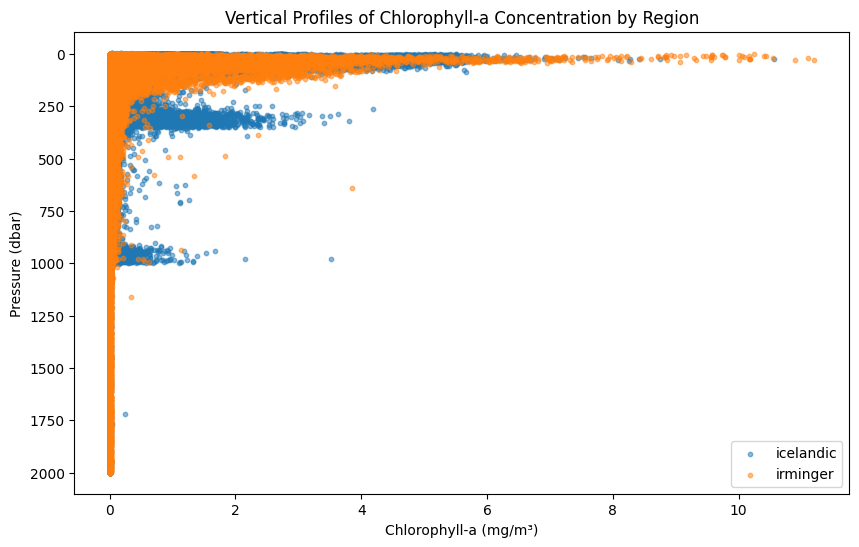

In [188]:
# Plotting scatter plot of vertical profiles of CHLA_ADJUSTED vs Depth per region
fig, ax = plt.subplots(figsize=(10, 6))
for region, group in df.to_pandas().groupby("region"):
    sc = ax.scatter(
        group["CHLA_ADJUSTED"],
        group["PRES_ADJUSTED"],
        s=10,
        alpha=0.5,
        label=region
    )
ax.invert_yaxis()
ax.set_xlabel("Chlorophyll-a (mg/m³)")
ax.set_ylabel("Pressure (dbar)")
ax.set_title("Vertical Profiles of Chlorophyll-a Concentration by Region")
ax.legend()
plt.show()

In [189]:
# Measuring how many profiles have a depth value of 1m or less 
print(f"Total Number of profiles: {df.select(['PLATFORM_NUMBER', 'CYCLE_NUMBER']).unique().height}")
print(f"Number of profiles with a depth value of 1m: {df.filter(pl.col('PRES_ADJUSTED') <= 1).select(['PLATFORM_NUMBER', 'CYCLE_NUMBER']).unique().height}")   

Total Number of profiles: 2910
Number of profiles with a depth value of 1m: 135


### CHL Time series

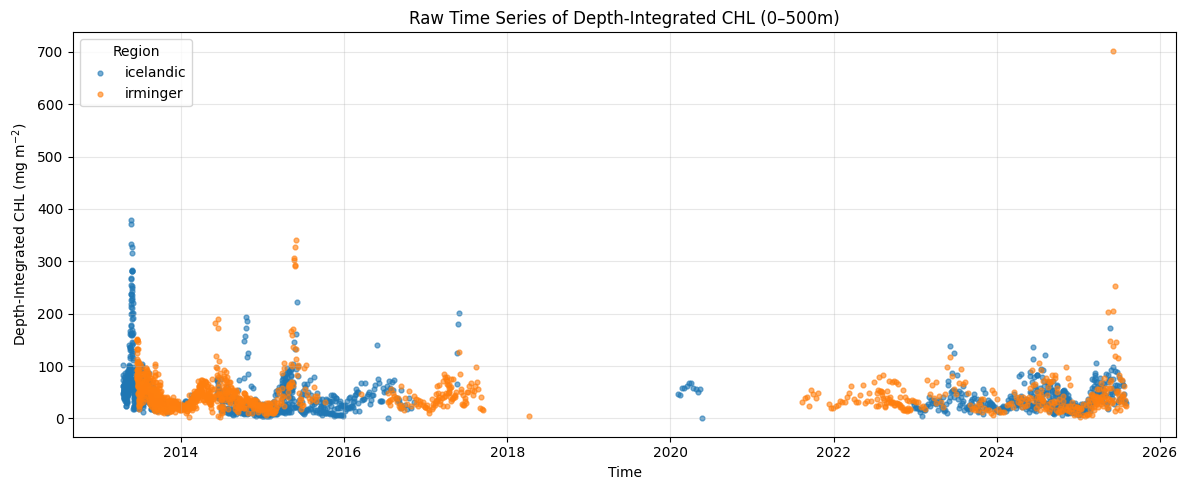

In [190]:
# Plotting a CHL time series per region
profiles_pd = profiles.to_pandas()
profiles_pd["TIME"] = pd.to_datetime(profiles_pd["TIME"])

plt.figure(figsize=(12, 5))

for region_name, group in profiles_pd.groupby("region"):
    plt.scatter(
        group["TIME"],
        group["DEPTH_INT_CHL"],
        s=12,
        alpha=0.6,
        label=region_name
    )

plt.title("Raw Time Series of Depth-Integrated CHL (0–500m)")
plt.xlabel("Time")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()


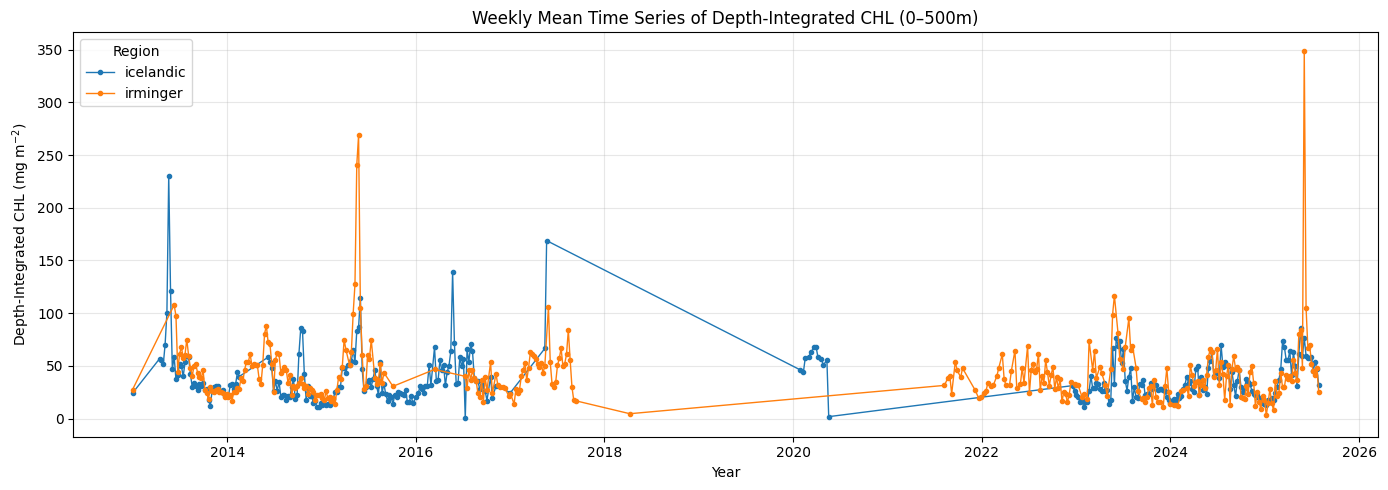

In [191]:
profiles_pd["year"] = profiles_pd["TIME"].dt.year
profiles_pd["week"] = profiles_pd["TIME"].dt.isocalendar().week.astype(int)

weekly_ts = (
    profiles_pd
    .groupby(["region", "year", "week"])
    .agg(
        DEPTH_INT_CHL_mean=("DEPTH_INT_CHL", "mean"),
        DEPTH_INT_CHL_std=("DEPTH_INT_CHL", "std"),
        n_profiles=("DEPTH_INT_CHL", "size"),
    )
    .reset_index()
)

weekly_ts["date"] = pd.to_datetime(
    weekly_ts["year"].astype(str) + "-W" +
    weekly_ts["week"].astype(str) + "-1",
    format="%G-W%V-%u"
)

plt.figure(figsize=(14, 5))

for region_name, group in weekly_ts.groupby("region"):
    group = group.sort_values("date")

    plt.plot(
        group["date"],
        group["DEPTH_INT_CHL_mean"],
        linewidth=1,
        marker="o",
        markersize=3,
        label=region_name
    )

plt.title("Weekly Mean Time Series of Depth-Integrated CHL (0–500m)")
plt.xlabel("Year")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

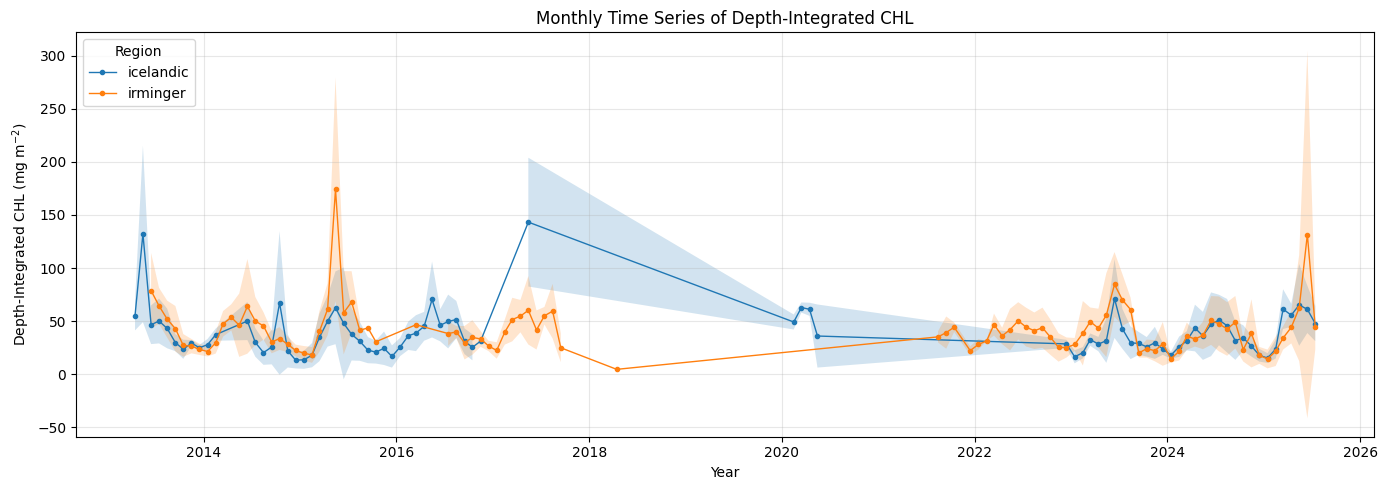

In [192]:
# Extract year and month
profiles_pd["year"] = profiles_pd["TIME"].dt.year
profiles_pd["month"] = profiles_pd["TIME"].dt.month   # calendar month

# Group: region × year × month
monthly_ts = (
    profiles_pd
    .groupby(["region", "year", "month"])
    .agg(
        DEPTH_INT_CHL_mean=("DEPTH_INT_CHL", "mean"),
        DEPTH_INT_CHL_std=("DEPTH_INT_CHL", "std"),
        n_profiles=("DEPTH_INT_CHL", "size"),
    )
    .reset_index()
)

# Build a datetime for the middle of each month
monthly_ts["date"] = pd.to_datetime(
    monthly_ts["year"].astype(str) + "-" +
    monthly_ts["month"].astype(str) + "-15"
)

# Plot
plt.figure(figsize=(14, 5))

for region_name, group in monthly_ts.groupby("region"):
    group = group.sort_values("date")

    plt.plot(
        group["date"],
        group["DEPTH_INT_CHL_mean"],
        linewidth=1,
        marker="o",
        markersize=3,
        label=region_name
    )

    # shading
    plt.fill_between(
        group["date"],
        group["DEPTH_INT_CHL_mean"] - group["DEPTH_INT_CHL_std"],
        group["DEPTH_INT_CHL_mean"] + group["DEPTH_INT_CHL_std"],
        alpha=0.2
    )

plt.title("Monthly Time Series of Depth-Integrated CHL")
plt.xlabel("Year")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

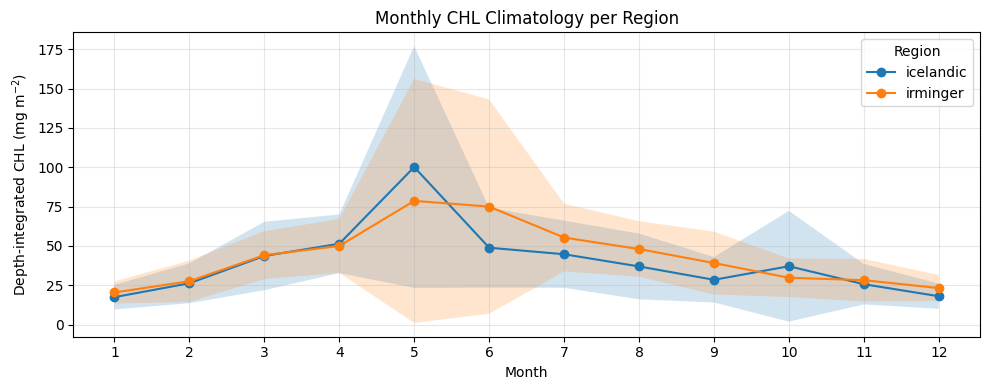

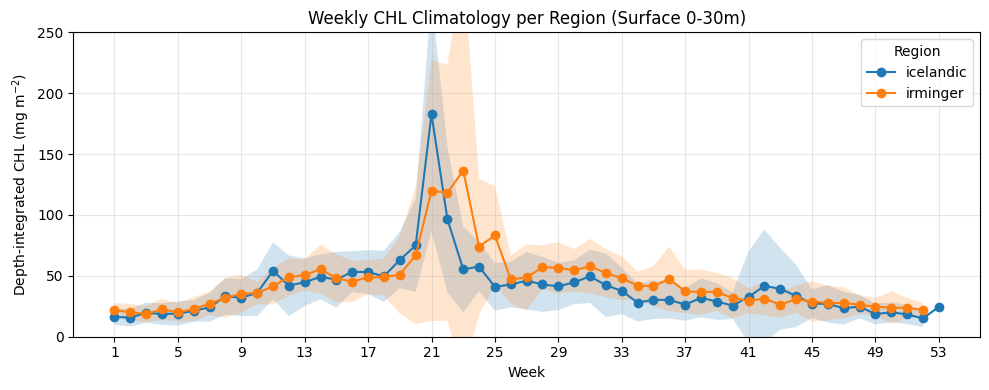

In [193]:


monthly_clim = (
    profiles
    .group_by(["region", "month"])
    .agg([
        pl.col("DEPTH_INT_CHL").mean().alias("DEPTH_INT_CHL_clim"),
        pl.col("DEPTH_INT_CHL").std().alias("DEPTH_INT_CHL_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "month"])
)

week_clim = (
    profiles
    .group_by(["region", "week"])
    .agg([
        pl.col("DEPTH_INT_CHL").mean().alias("DEPTH_INT_CHL_clim"),
        pl.col("DEPTH_INT_CHL").std().alias("DEPTH_INT_CHL_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "week"])
)

# Convert to pandas for easy plotting
clim_pd = monthly_clim.to_pandas()
climw_pd = week_clim.to_pandas()

plt.figure(figsize=(10, 4))

for region_name, group in clim_pd.groupby("region"):
    group = group.sort_values("month")
    
    plt.plot(
        group["month"],
        group["DEPTH_INT_CHL_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    plt.fill_between(
        group["month"],
        group["DEPTH_INT_CHL_clim"] - group["DEPTH_INT_CHL_std"],
        group["DEPTH_INT_CHL_clim"] + group["DEPTH_INT_CHL_std"],
        alpha=0.2,
    )

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")
plt.title("Monthly CHL Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for region_name, group in climw_pd.groupby("region"):
    group = group.sort_values("week")
    
    plt.plot(
        group["week"],
        group["DEPTH_INT_CHL_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    plt.fill_between(
        group["week"],
        group["DEPTH_INT_CHL_clim"] - group["DEPTH_INT_CHL_std"],
        group["DEPTH_INT_CHL_clim"] + group["DEPTH_INT_CHL_std"],
        alpha=0.2,
    )
plt.xticks(range(1, 54))
plt.xlabel("Week")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")   
#limiting y range from 0 to 300 mg m^-2
plt.ylim(0, 250) 
plt.title("Weekly CHL Climatology per Region (Surface 0-30m)")
# ax.set_xticks(np.arange(1, 53, 4)) addding every 4 weeks
plt.xticks(ticks=np.arange(1, 54, 4))
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

### Euphotic zone integration
Calculating Euphotic zone based Intially based on Morel & Maritonera 2001
Now based on 1% rule

In [194]:
# Selecting one profile for testing
df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')




depth_m = profile["PRES_ADJUSTED"].to_numpy()
ed490 = profile["DOWN_IRRADIANCE490_ADJUSTED"].to_numpy()
DOWNWELLING_PAR_ADJUSTED = profile["DOWNWELLING_PAR_ADJUSTED"].to_numpy()

In [195]:
# Masking Top

mask = (depth_m >= 10) & (depth_m <= 10)

depth_m_top = depth_m[mask]
ed490_top = ed490[mask]
DOWNWELLING_PAR_ADJUSTED_top = DOWNWELLING_PAR_ADJUSTED[mask]

# VAlid points finate and > 0
valid_490 = np.isfinite(ed490_top) & (ed490_top > 0)
valid_DOWNWELLING_PAR_ADJUSTED = np.isfinite(DOWNWELLING_PAR_ADJUSTED_top) & (DOWNWELLING_PAR_ADJUSTED_top > 0)

#if valid_490.sum() < 5 or valid_DOWNWELLING_PAR_ADJUSTED.sum() < 5:
#    raise ValueError("Not enough valid points in top 10 m for this profile")

In [ ]:
import polars as pl
import pandas as pd
import xarray as xr
import numpy as np
from scipy import stats
from numpy.polynomial import Polynomial

import matplotlib.pyplot as plt




In [197]:
# Gathering BGC data

df = pd.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')



Index(['BBP532', 'BBP532_ADJUSTED', 'BBP532_ADJUSTED_ERROR',
       'BBP532_ADJUSTED_QC', 'BBP532_DATA_MODE', 'BBP532_QC', 'BBP700',
       'BBP700_ADJUSTED', 'BBP700_ADJUSTED_ERROR', 'BBP700_ADJUSTED_QC',
       ...
       'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR', 'TEMP_ADJUSTED_QC',
       'TEMP_DATA_MODE', 'TEMP_QC', 'TIME_QC', 'LATITUDE', 'LONGITUDE', 'TIME',
       'region'],
      dtype='object', length=106)

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy.polynomial import Polynomial

def process_radiometry_profile(df_profile, top_depth=10, min_points=5):
    """
    df_profile: dataframe containing one profile (one PLATFORM + CYCLE)
    Must include columns: depth, Ed490, iPAR
    –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
    Returns:
        dict containing surface Ed, surface iPAR, Kd functions and Zeu.
    –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
    """
    
    z = df_profile["depth"].values
    Ed = df_profile["Ed490"].values
    PAR = df_profile["iPAR"].values
    
    # --- Select values in 0–10 m
    mask = (z >= 0) & (z <= top_depth)
    z_top = z[mask]
    Ed_top = Ed[mask]
    PAR_top = PAR[mask]

    # Require minimum valid points
    if np.count_nonzero(~np.isnan(Ed_top)) < min_points:
        return None  # Cannot process Ed

    if np.count_nonzero(~np.isnan(PAR_top)) < min_points:
        return None  # Cannot process PAR

    # --- 1. Fit ln(Ed490) linear regression
    valid_490 = (~np.isnan(Ed_top)) & (Ed_top > 0)
    slope_490, intercept_490, *_ = stats.linregress(
        z_top[valid_490], np.log(Ed_top[valid_490])
    )
    Ed_surface = np.exp(intercept_490)

    # --- 2. Fit ln(iPAR) second-degree polynomial
    valid_PAR = (~np.isnan(PAR_top)) & (PAR_top > 0)
    poly_PAR = Polynomial.fit(
        z_top[valid_PAR], np.log(PAR_top[valid_PAR]), deg=2
    )
    PAR_surface = np.exp(poly_PAR(0))

    # --- 3. Define Kd calculators
    def Kd_490(z_eval, Ed_z):
        return (1.0 / z_eval) * np.log(Ed_surface / Ed_z)

    def Kd_PAR(z_eval, PAR_z):
        return (1.0 / z_eval) * np.log(PAR_surface / PAR_z)

    # --- 4. Compute Zeu (PAR = 1% of surface)
    # Solve: PAR(z) = PAR_surface * exp(-Kd * z)
    # ⇒ z = 4.605 / Kd
    # We'll approximate using Kd(PAR) at the deepest valid measurement.

    # pick deepest valid PAR
    valid_depths = df_profile[~df_profile["iPAR"].isna()].sort_values("depth")
    deepest_row = valid_depths.iloc[-1]
    z_d = deepest_row["depth"]
    PAR_d = deepest_row["iPAR"]
    
    Kd_est = Kd_PAR(z_d, PAR_d)
    Zeu = 4.605 / Kd_est

    return {
        "Ed0": Ed_surface,
        "PAR0": PAR_surface,
        "Kd_func_490": Kd_490,
        "Kd_func_PAR": Kd_PAR,
        "Kd_PAR_est": Kd_est,
        "Zeu": Zeu
    }

In [199]:
results = []

for (pn, cn), group in df.groupby(["PLATFORM_NUMBER", "CYCLE_NUMBER"]):
    out = process_radiometry_profile(group)
    if out is not None:
        out["PLATFORM_NUMBER"] = pn
        out["CYCLE_NUMBER"] = cn
        results.append(out)

KeyError: 'depth'

In [ ]:
results_df = pd.DataFrame(results)
results_df.head()